# Hackathon Oil&Gas: Data Warehouse

In order to properly run this Notebook properly, please install the notebook extensions and the qgrid package.

Remember: 

<b> Qgrid </b> 
<br>
Installing with conda:
<br>
only required if you have not added conda-forge to your channels yet
<br>
conda config --add channels conda-forge
<br>
conda install qgrid

pip install qgrid:
<br>
jupyter nbextension enable --py --sys-prefix qgrid
<br>
only required if you have not enabled the ipywidgets nbextension yet
<br>
jupyter nbextension enable --py --sys-prefix widgetsnbextension

<b> Jupyter extensions: </b> 
<br>
Installation with conda:
<br>
conda install -c conda-forge jupyter_nbextensions_configurator
<br>
conda install -c conda-forge jupyter_contrib_nbextensions

Or with pip:
<br>
pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install
<br>
#incase you get permission errors on MacOS,
<br>
pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user


Then in your localhost go to: http://localhost:8888/nbextensions?nbextension=codefolding/main and activate the folling extensions: codefolding, codefolding in editor, collapsible headings, table of contents, qgrid/extention

For a platform different to anaconda go to https://github.com/ipython-contrib/jupyter_contrib_nbextensions


<img src="./figs/extensions.png">


Once the installation is done, please activate the table of content for a better user experience 
<br>

<img src="./figs/toc.png">



## Participants
- Cindy Ortega - cindy.or03@gmail.com
- Nicolás Bueno - nbuenoz@unal.edu.co
- Alejandro Uribe - jduriber@unal.edu.co

## Libraries

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import downloadData
from utils import dataProc
from utils import generateDB
from pathlib import Path
from IPython.core.display import display, HTML
import qgrid

import seaborn; seaborn.set()
import pickle
from scipy.optimize import curve_fit
from calendar import monthrange

## Downloading, Loading & Cleanning Data

In [3]:
# Scrappes and downloads the data from ANH website
download = downloadData.downloadData()
download.getData()
data = dataProc.dataProc()
df = data.loadData()
df_dict = data.cleanData(df)

Scrapping started
Scrapping finished
Files downloaded
Loading data
Loading data finished
Cleanning data
Cleaning data finsihed


## Generating data for interface

In [4]:
#Generating HTML docs 

first= """<!DOCTYPE HTML>

<html lang="en">
<head>
	<meta charset="UTF-8">
	<!-- <meta name="viewport" content="width=device-width, initial-scale=1"> -->
	<title>Produccion en Colombia</title>

	<!-- Bootstrap core CSS -->
	<link rel="stylesheet" href="../assets/css/bootstrap.min.css">

	<!-- Bootstrap theme -->
	<!-- <link href="../assets/css/bootstrap-theme.min.css" rel="stylesheet"> -->

	<!-- Custom styles for this template -->
	<!-- <link href="../assets/css/theme.css" rel="stylesheet"> -->

  <body>

    <!-- Header -->
    <section id="header">
      <header>
        <h2>Produccion en Colombia</h2>
      </header>

      <!-- TABLE CODE START -->
      
      """

last="""

</section>
  </body>
</head>

<script src="../tablefilter/tablefilter.js"></script>

<script data-config="">
 var filtersConfig = {
  base_path: '../tablefilter/',
  auto_filter: {
		            delay: 110 //milliseconds
              },
              filters_row_index: 1,
              state: true,
              alternate_rows: true,
              rows_counter: true,
              btn_reset: true,
              status_bar: true,
              msg_filter: 'Filtering...'
            };
            var tf = new TableFilter('demo', filtersConfig);
            tf.init();
          </script>
          
"""

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


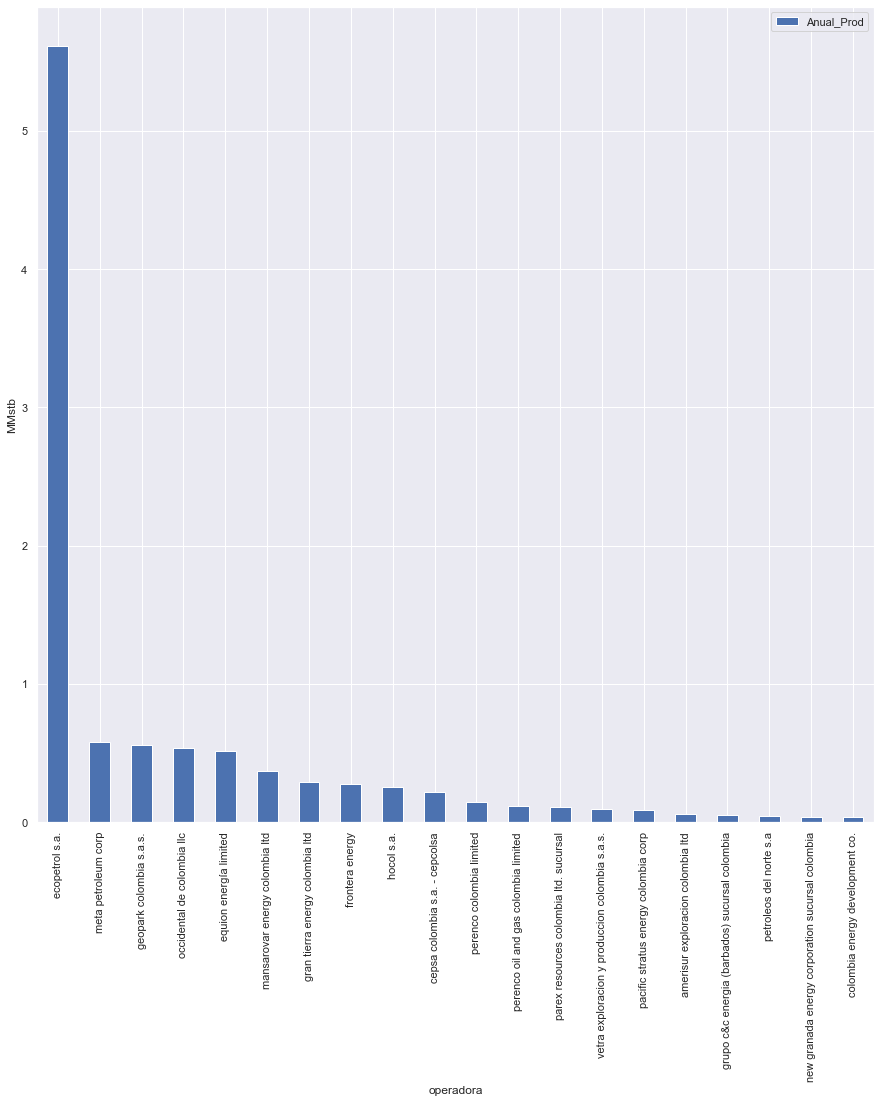

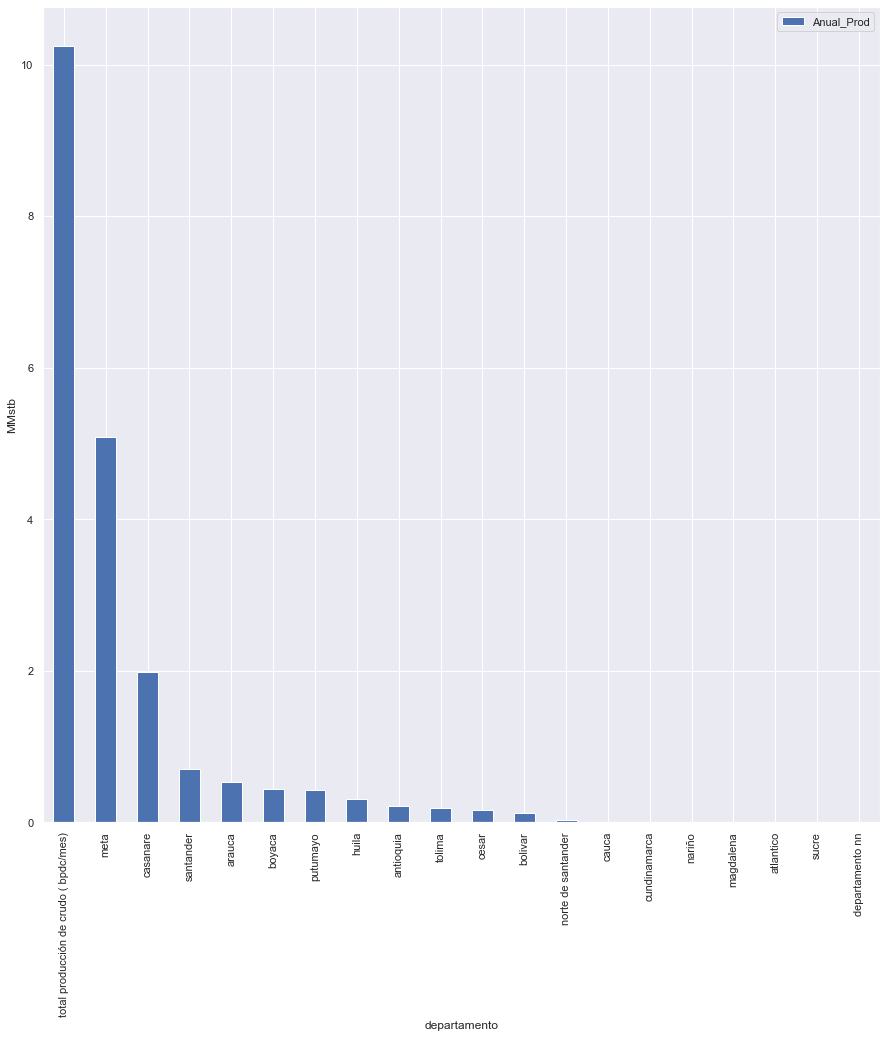

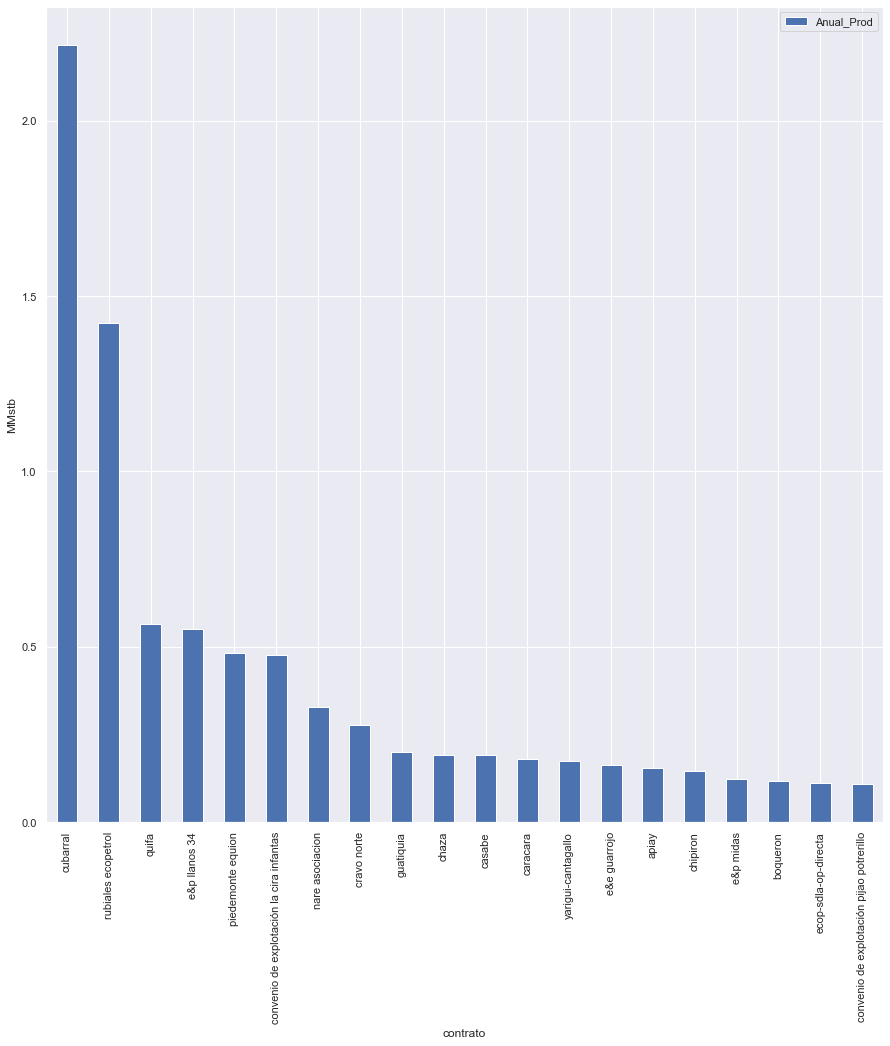

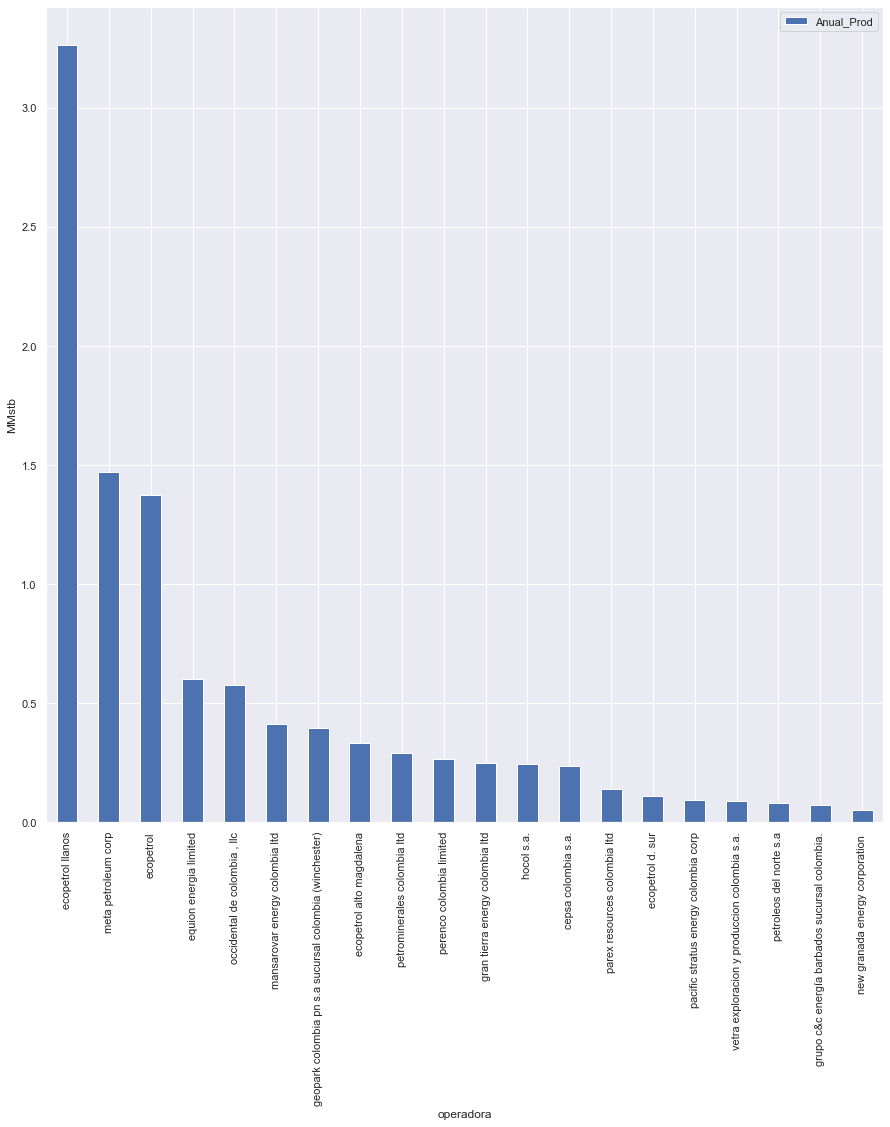

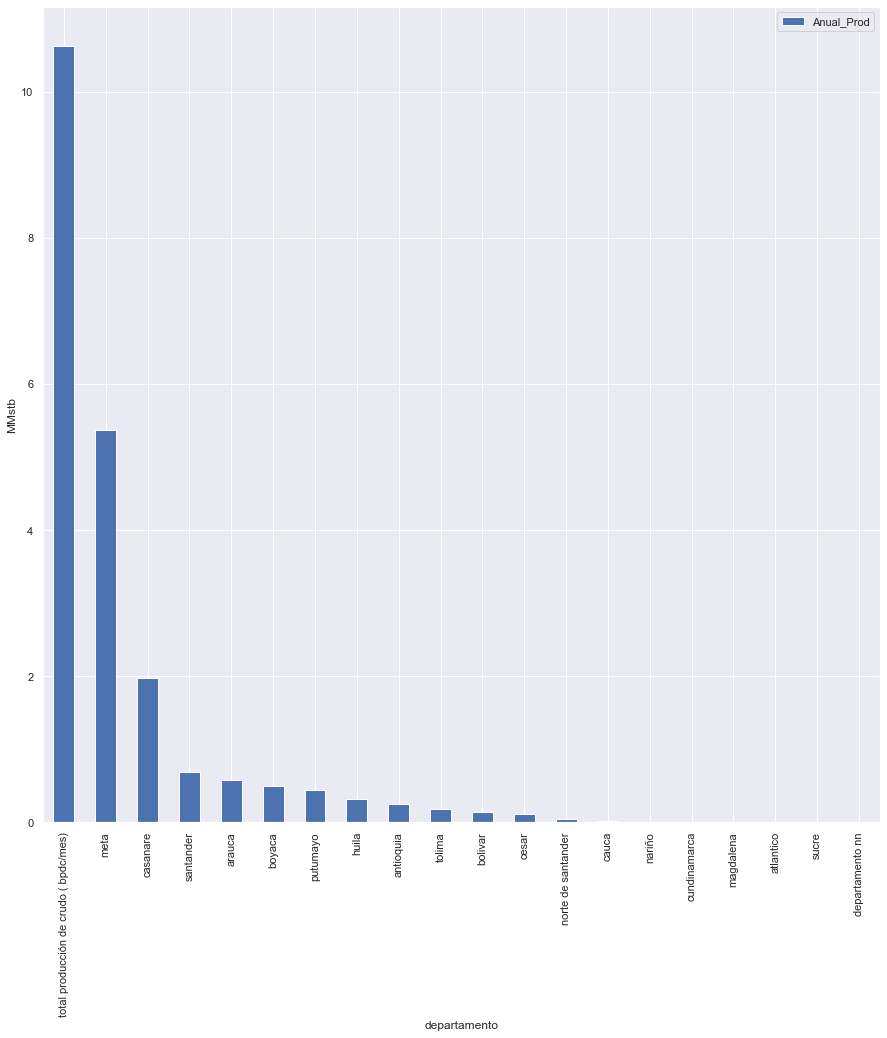

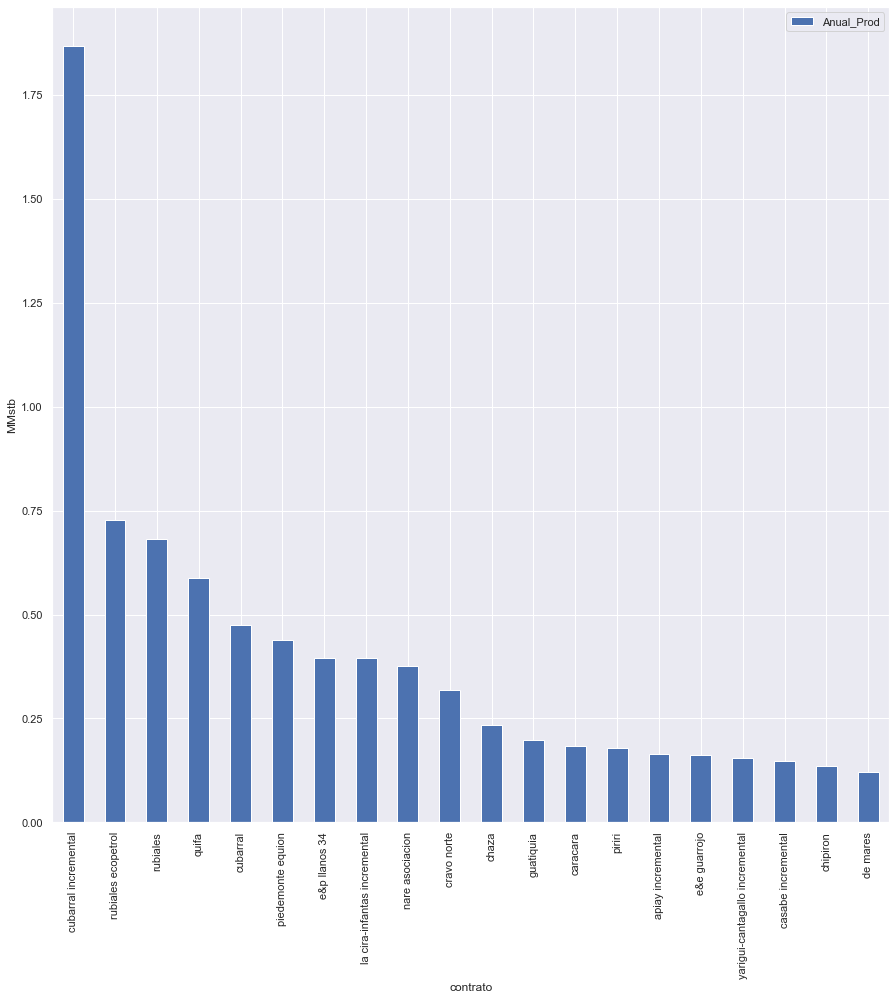

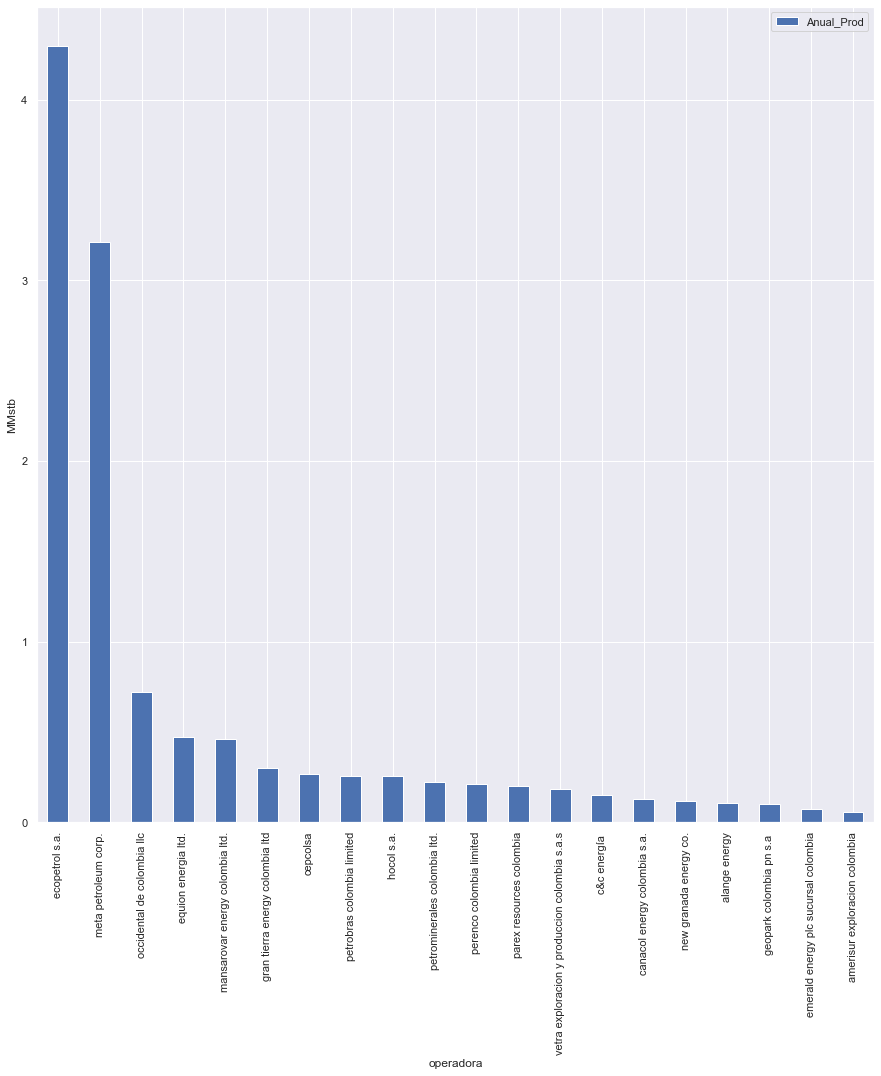

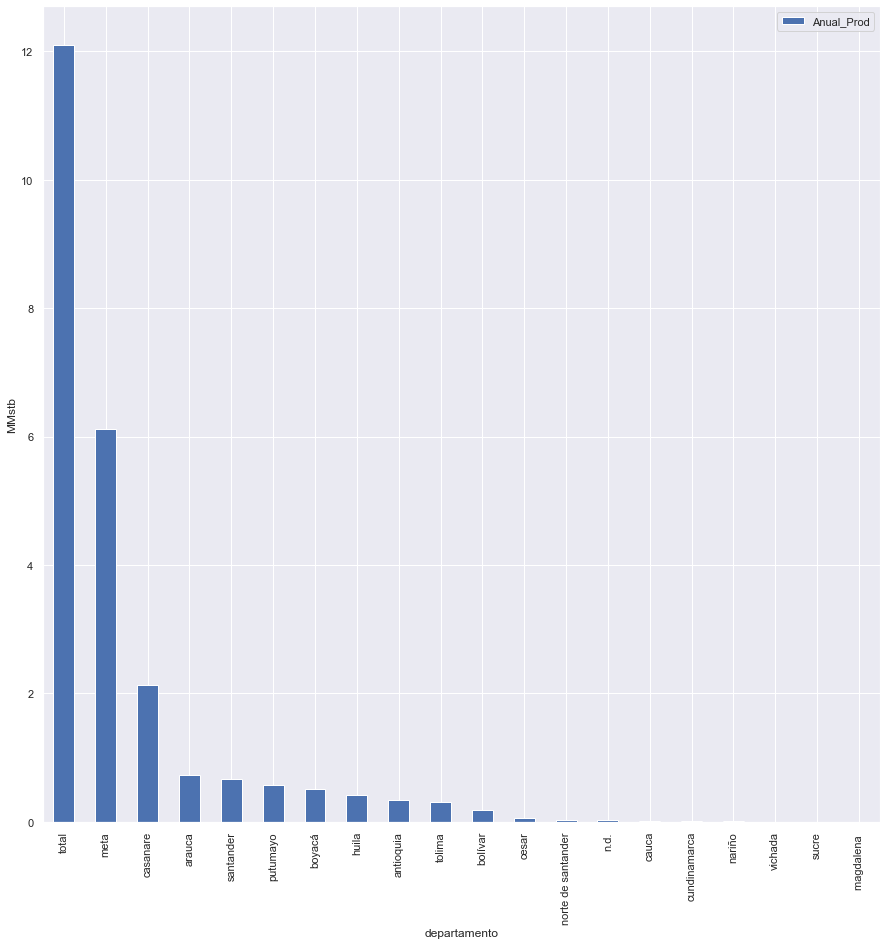

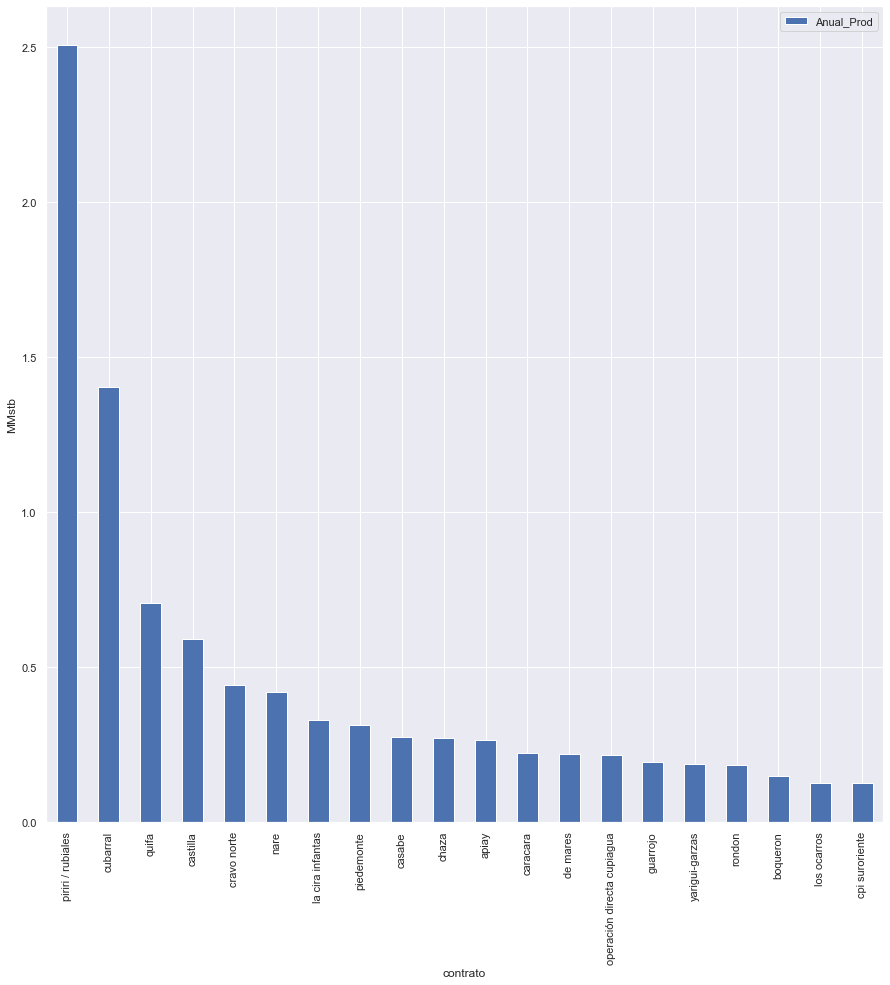

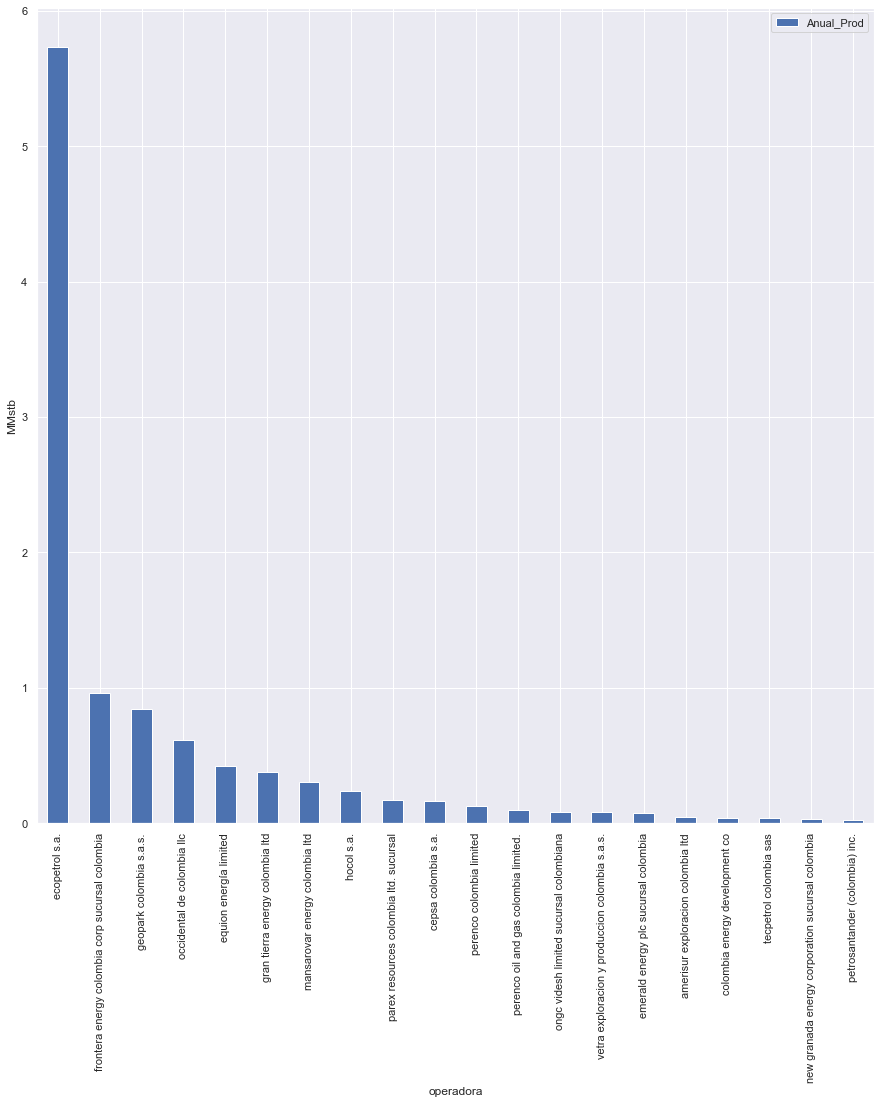

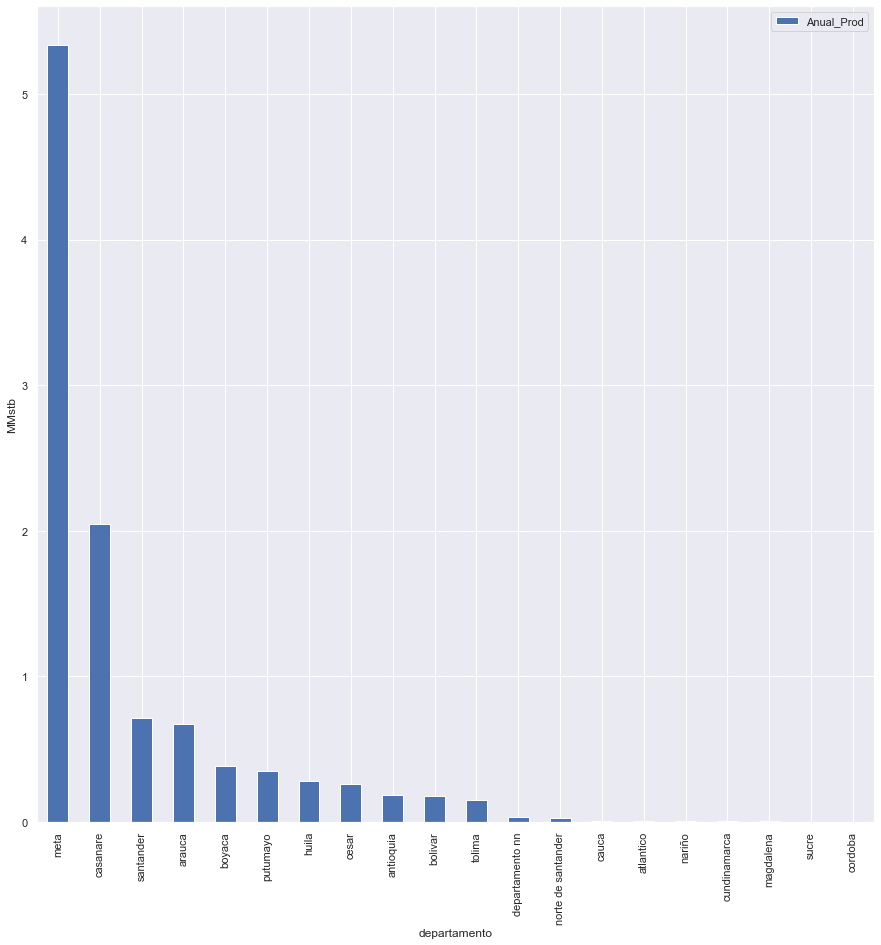

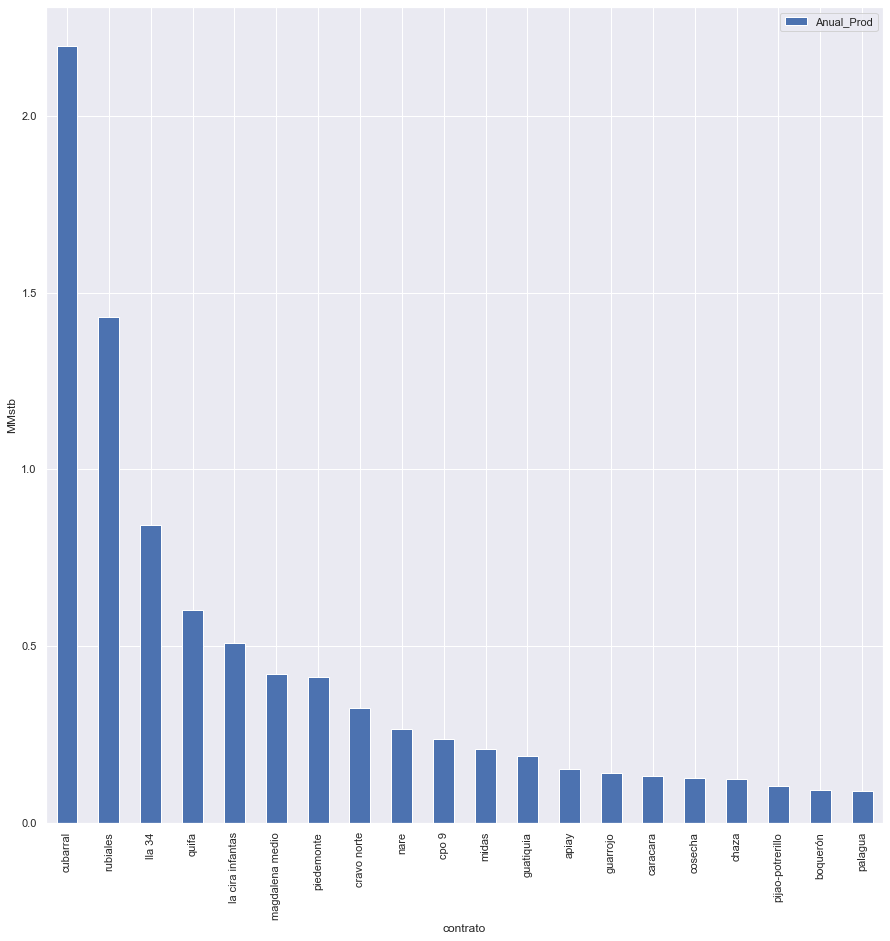

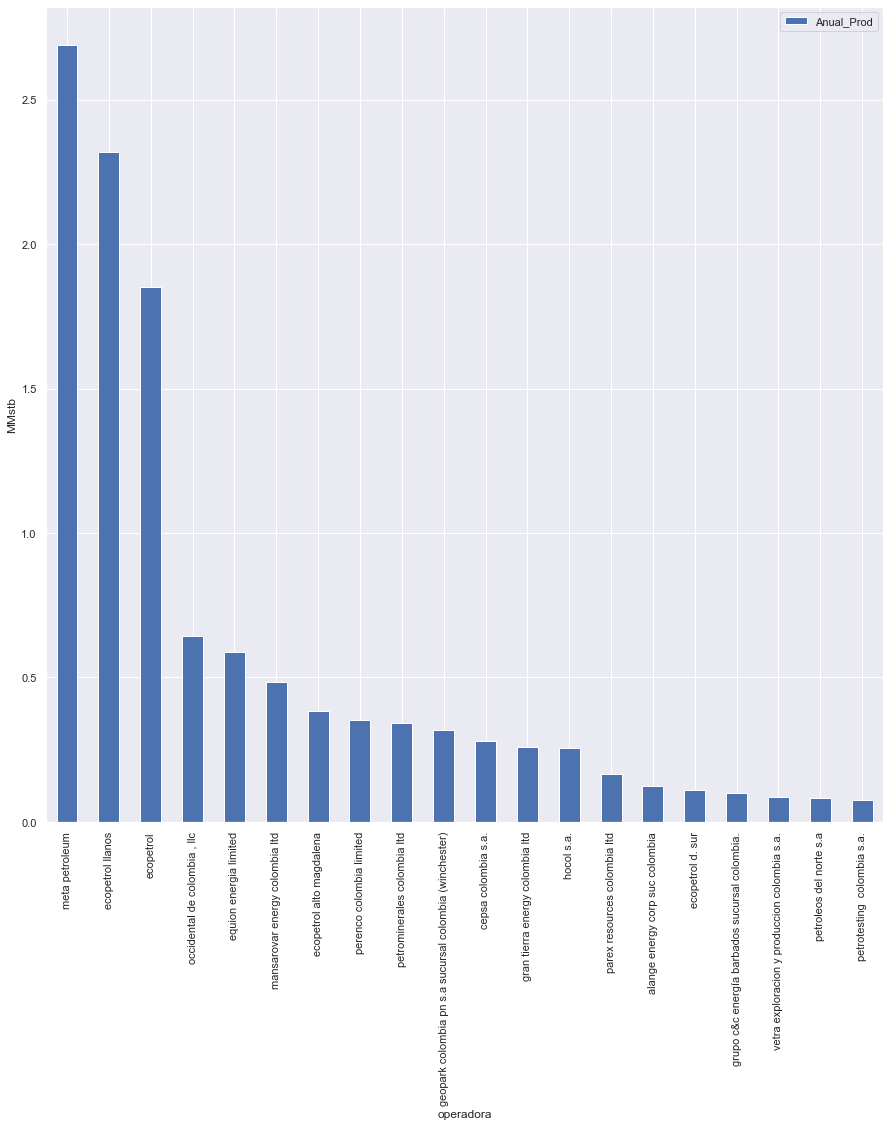

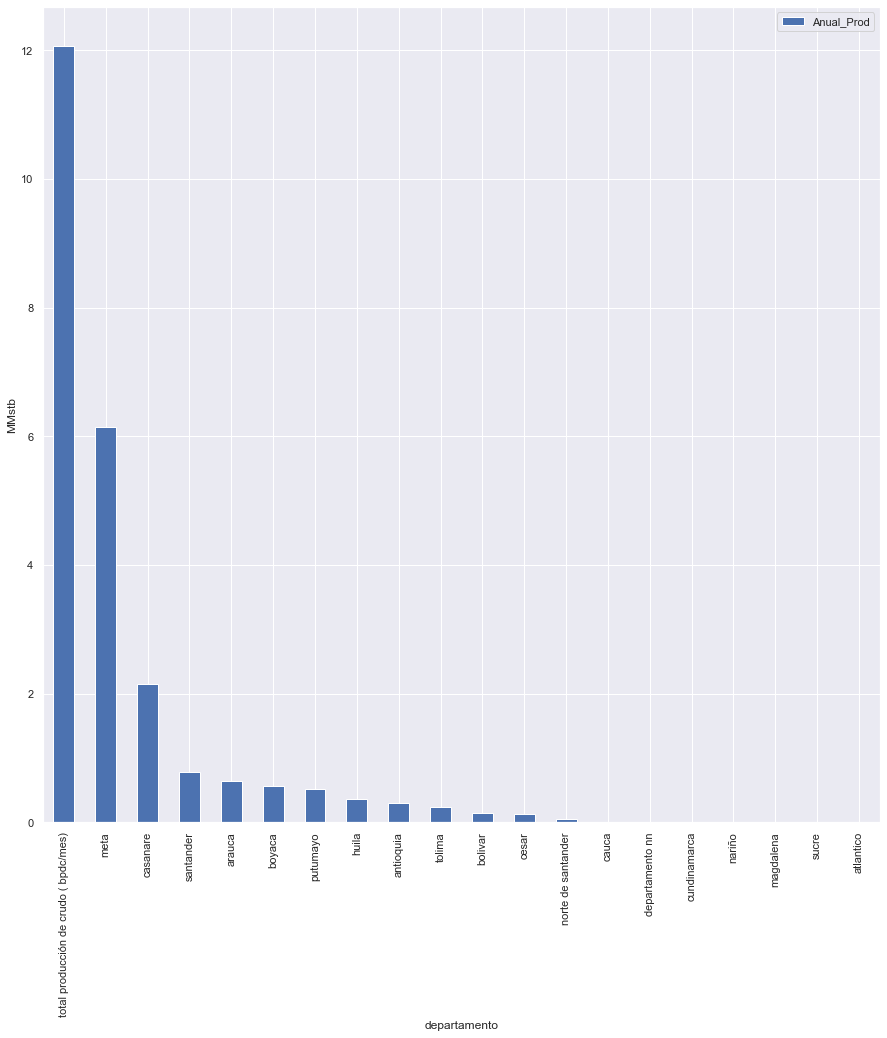

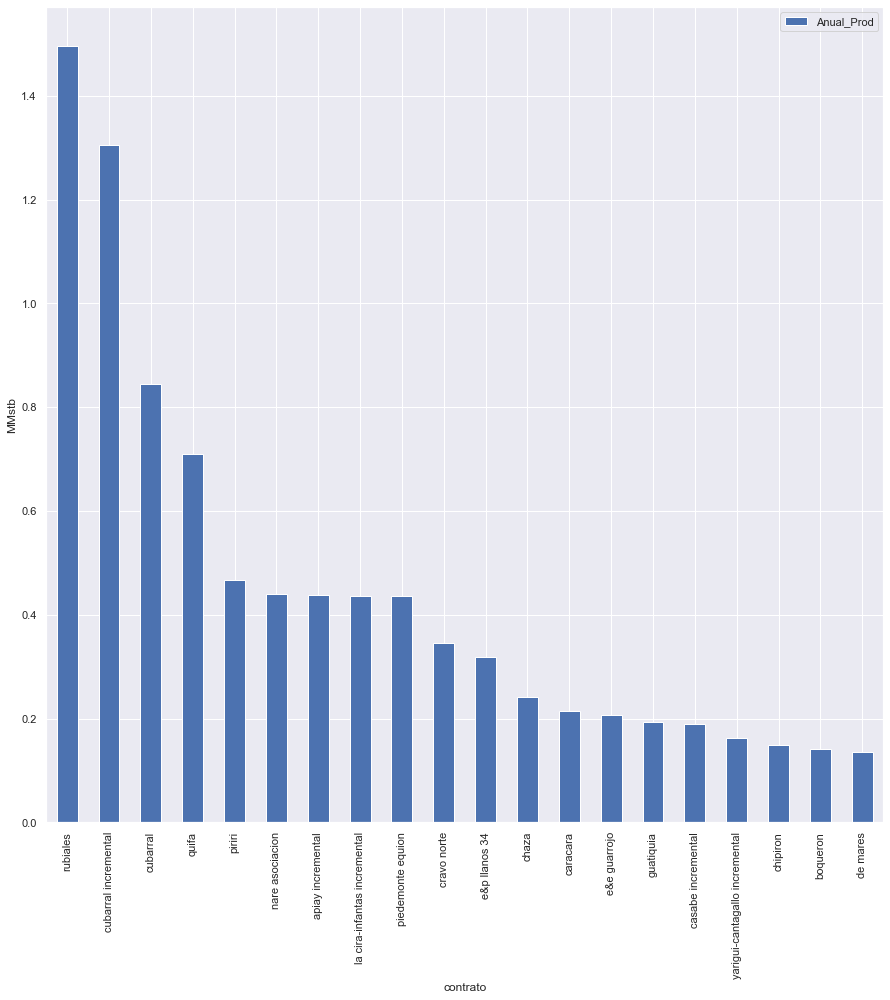

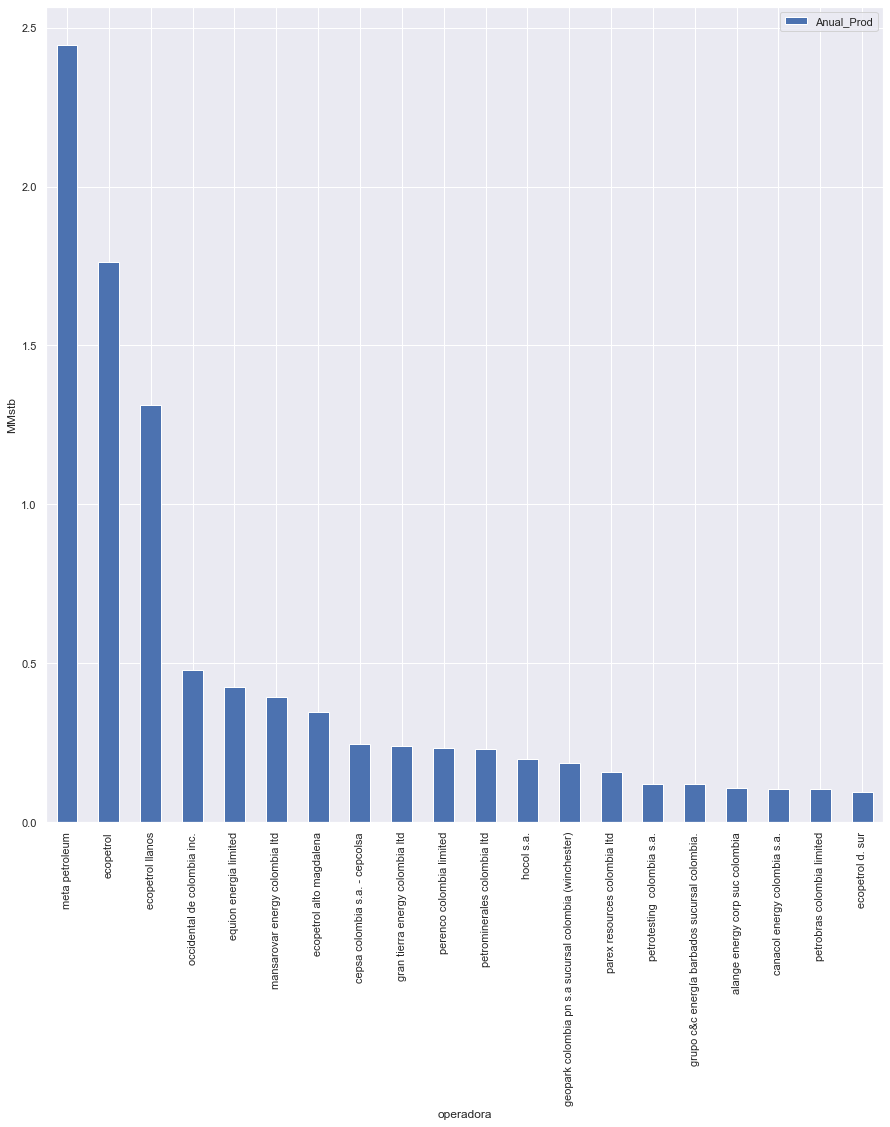

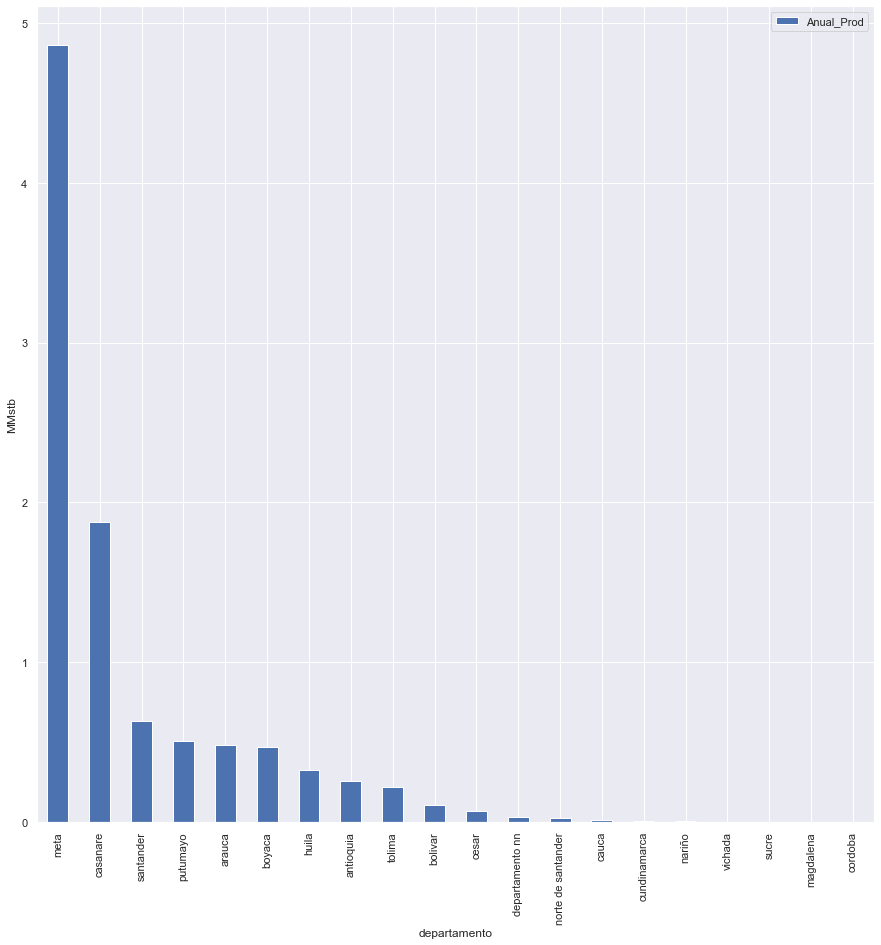

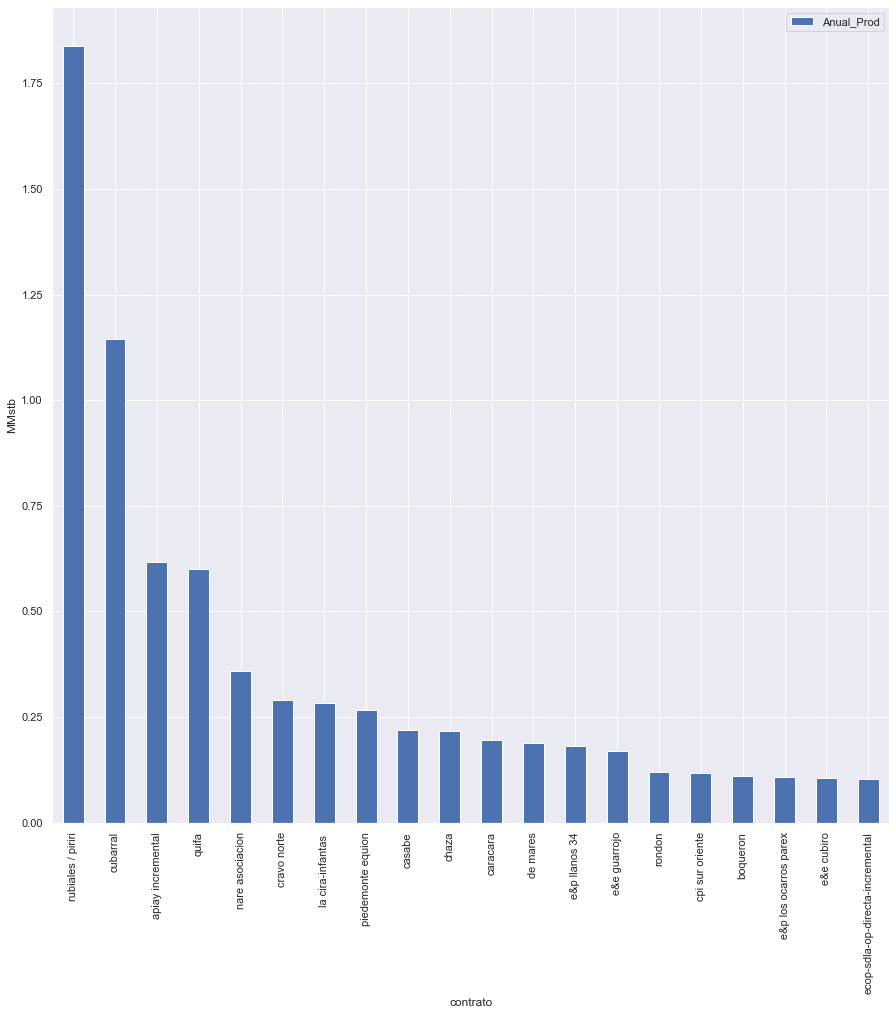

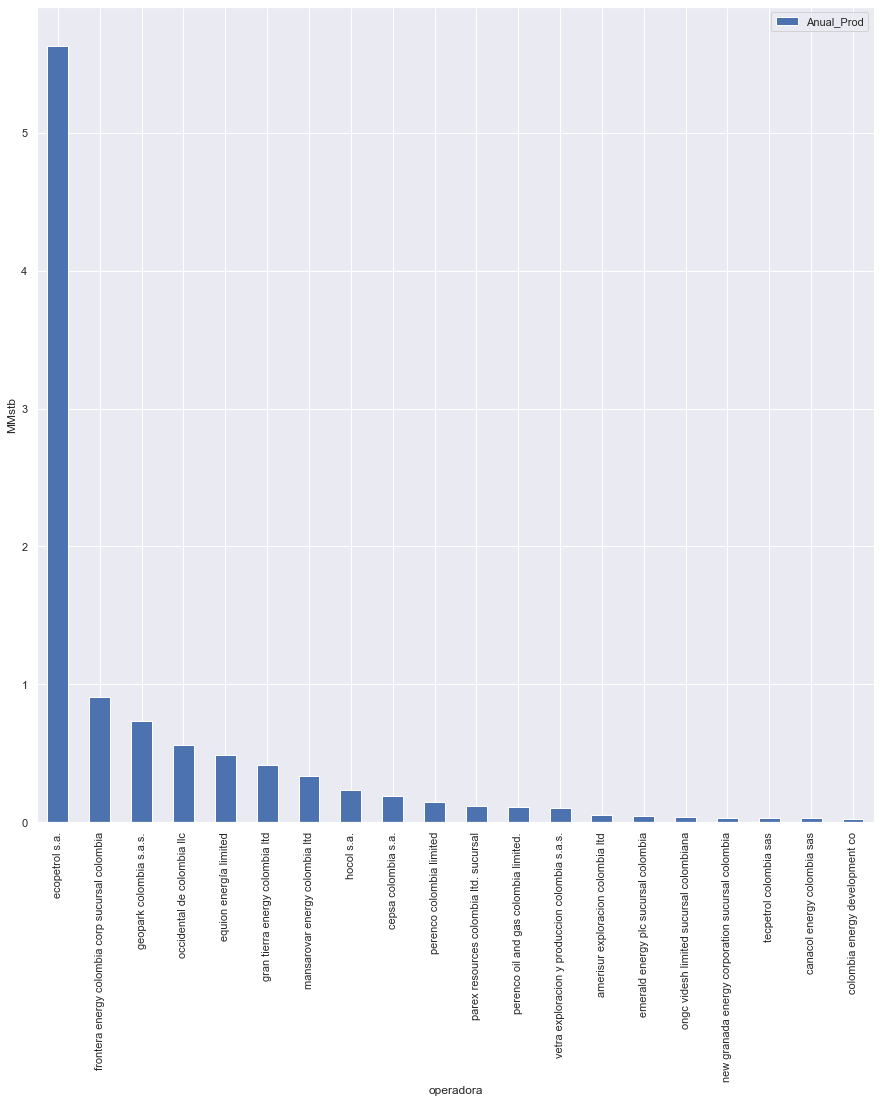

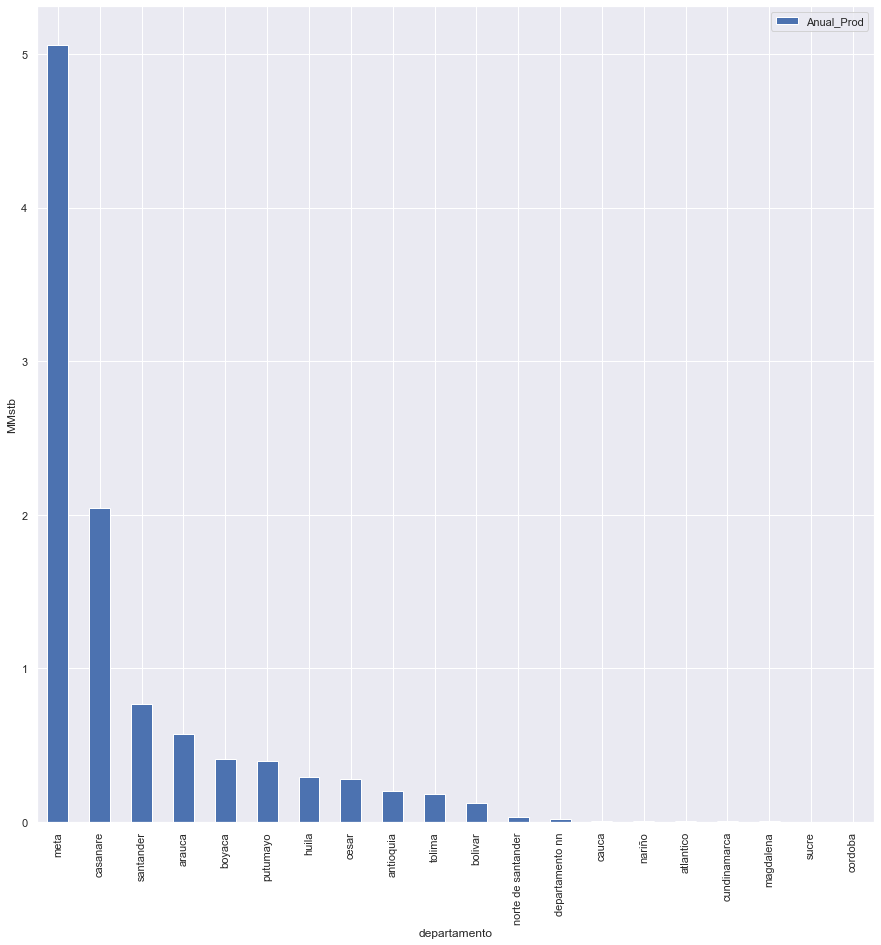

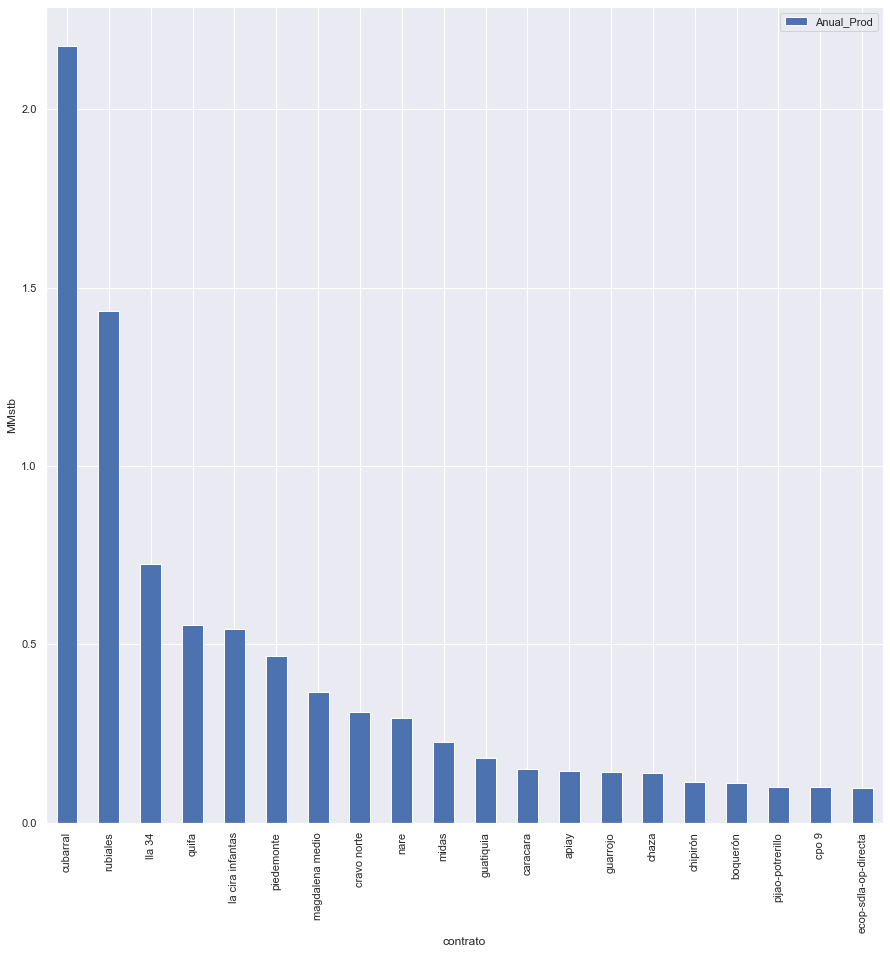

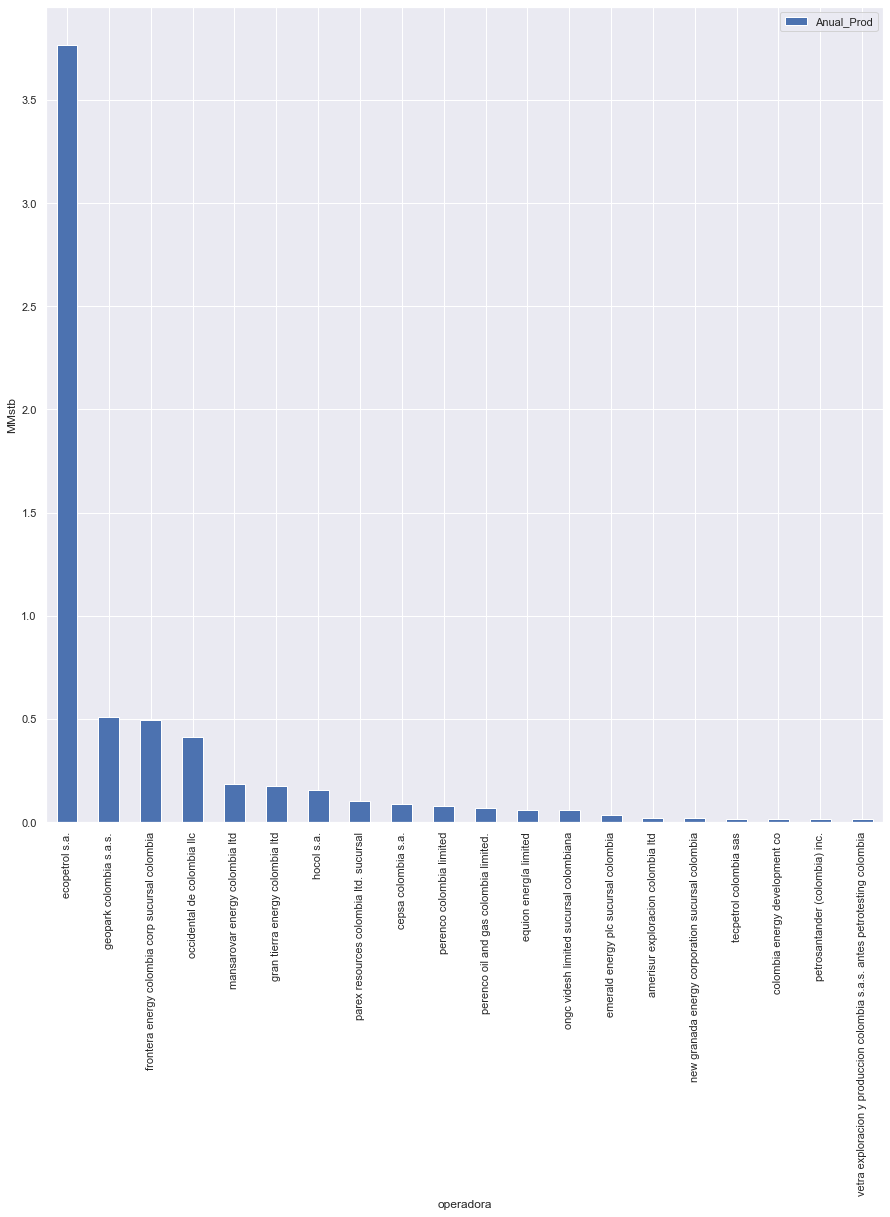

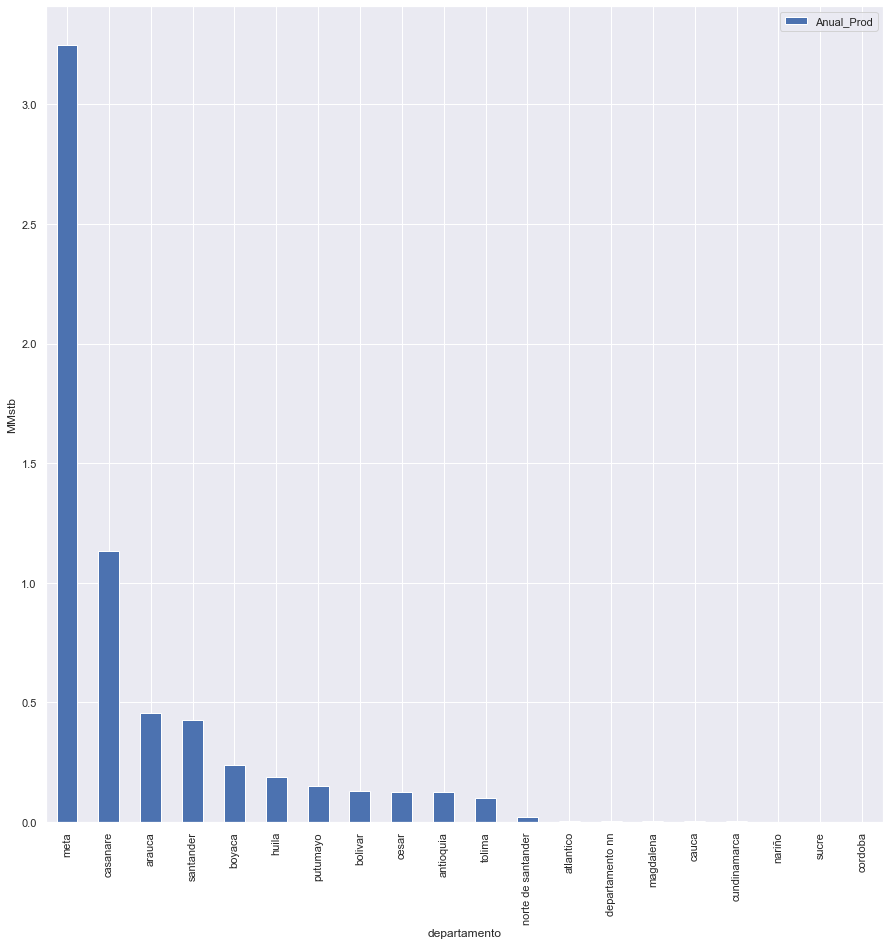

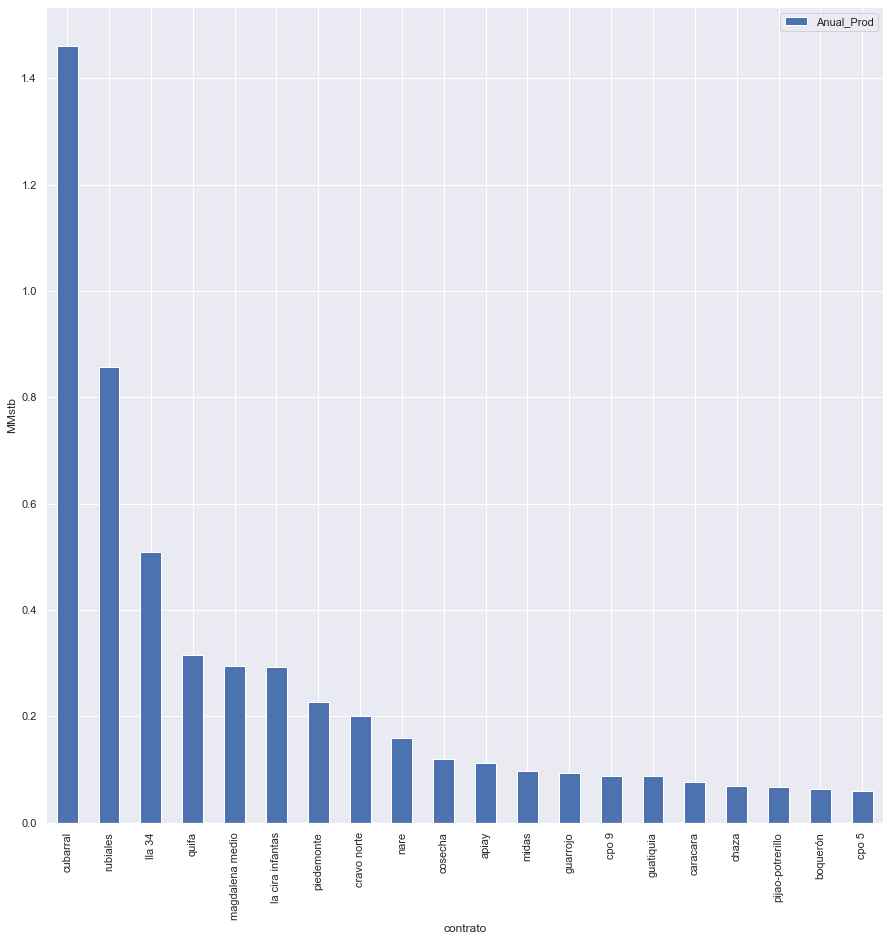

In [5]:
#Generating images for html 
groups=['operadora','departamento','contrato']

for i in df_dict.keys():
    test_html=df_dict[i].to_html()
    text_file = open(f"./interface/subpages/{i}.html", "w")
    text_file.write(first+ '\n'+test_html+ '\n'+last)
    text_file.close()
    # Read in the file
    with open(f"./interface/subpages/{i}.html", 'r') as file :
        filedata = file.read()
    # Replace the target string
    filedata = filedata.replace('<table border="1" class="dataframe">', '<table id="demo" border="1" class="dataframe">')
    filedata = filedata.replace('<h2>Produccion en Colombia</h2>', f'<h2>Produccion en Colombia {i}</h2>')
    # Write the file out again
    with open(f"./interface/subpages/{i}.html", 'w') as file:
        file.write(filedata)
    
    for j in groups:
        Production=df_dict[i].copy()
        Prod_Jan= Production.columns.get_loc("enero")        
        Production['Total_Prod']=(Production.iloc[:,Prod_Jan::].fillna(0).sum(axis=1))/1000000
        Production=Production.groupby(j)['Total_Prod'].sum().reset_index(name ='Anual_Prod')
        Production=Production.sort_values(by=['Anual_Prod'], ascending=False).iloc[0:20,:].reset_index(drop=True)
        Production.plot(x=j, y='Anual_Prod', kind="bar",figsize=(15,10))
        plt.xlabel(j)
        plt.ylabel('MMstb')
        plt.savefig(f'./interface/figs/{j,i}.png', bbox_inches = 'tight', pad_inches = 0)


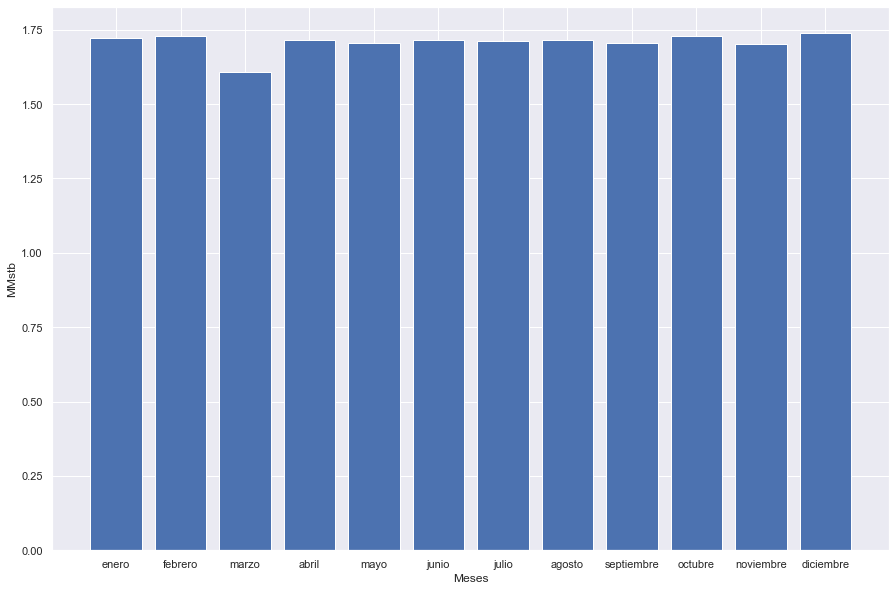

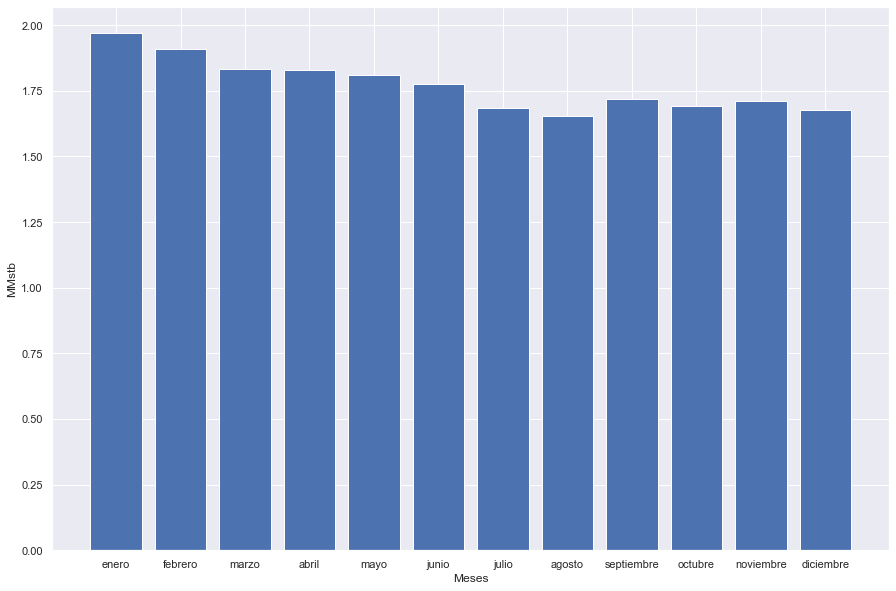

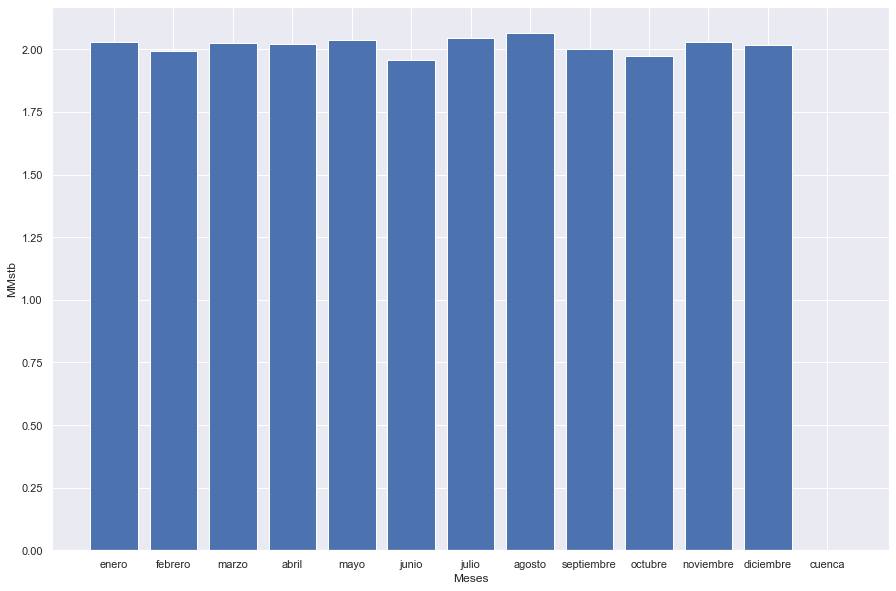

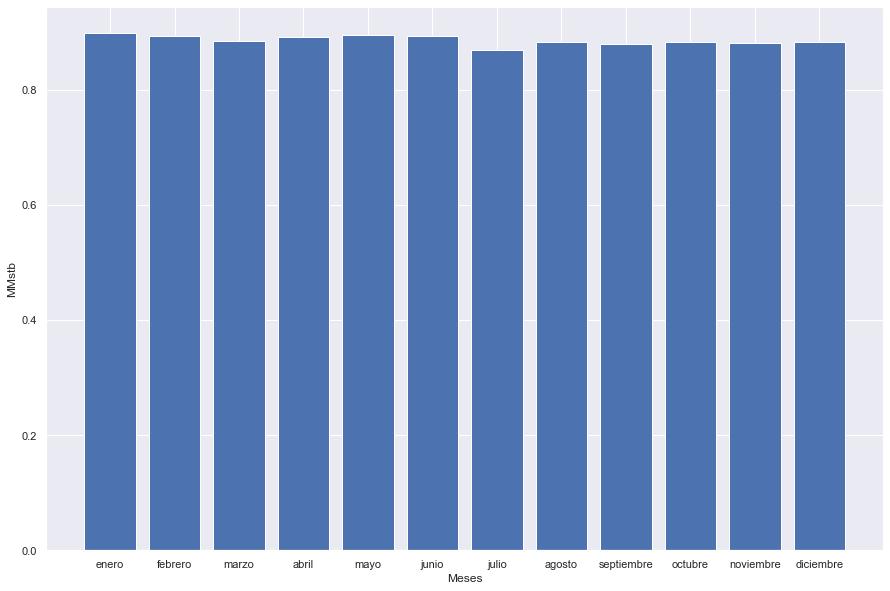

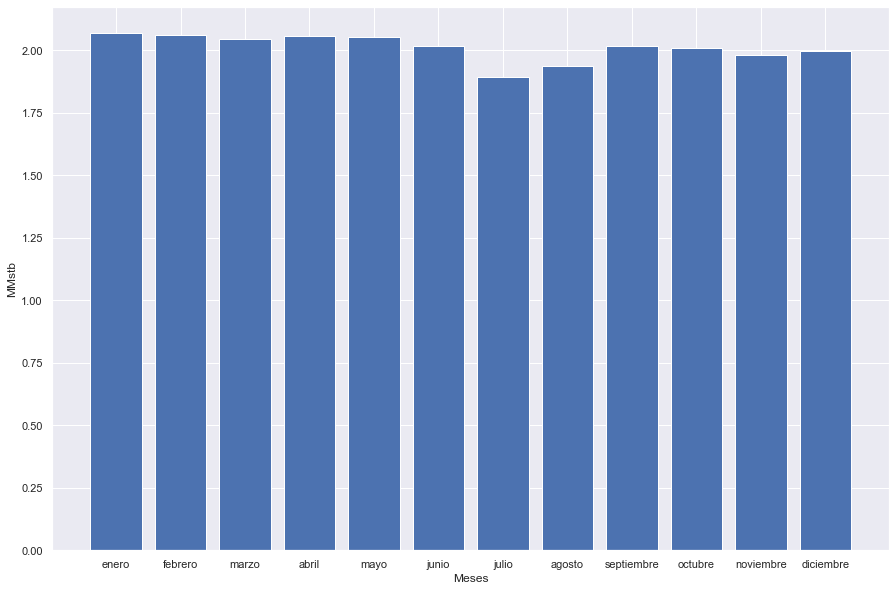

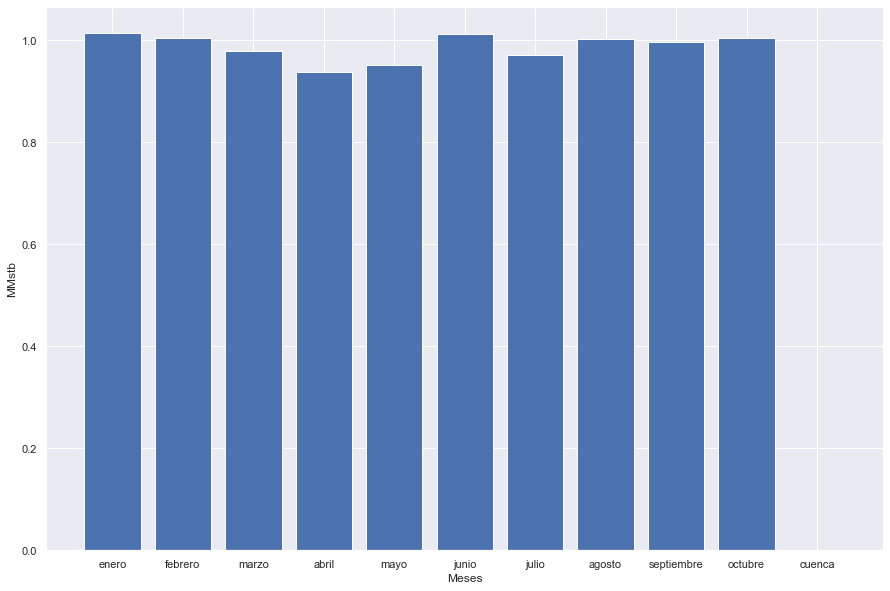

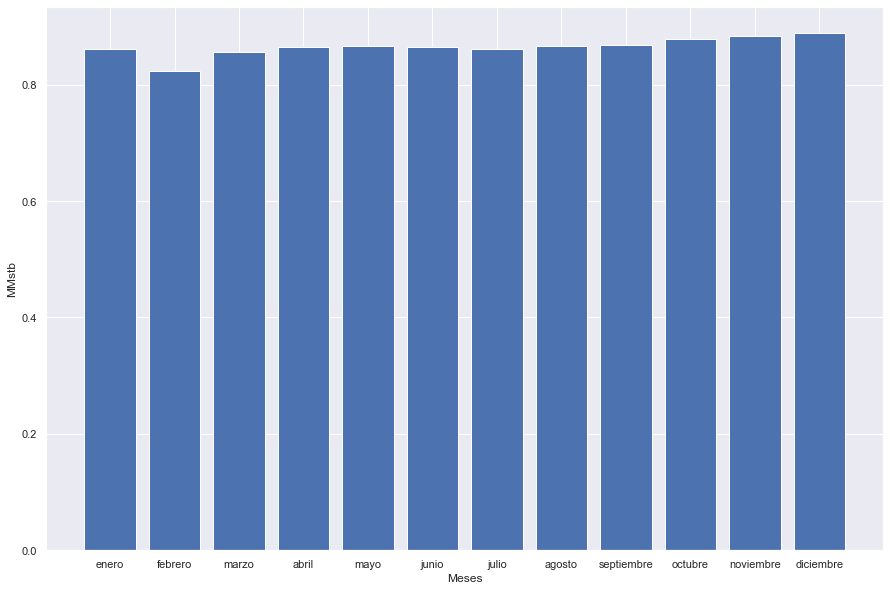

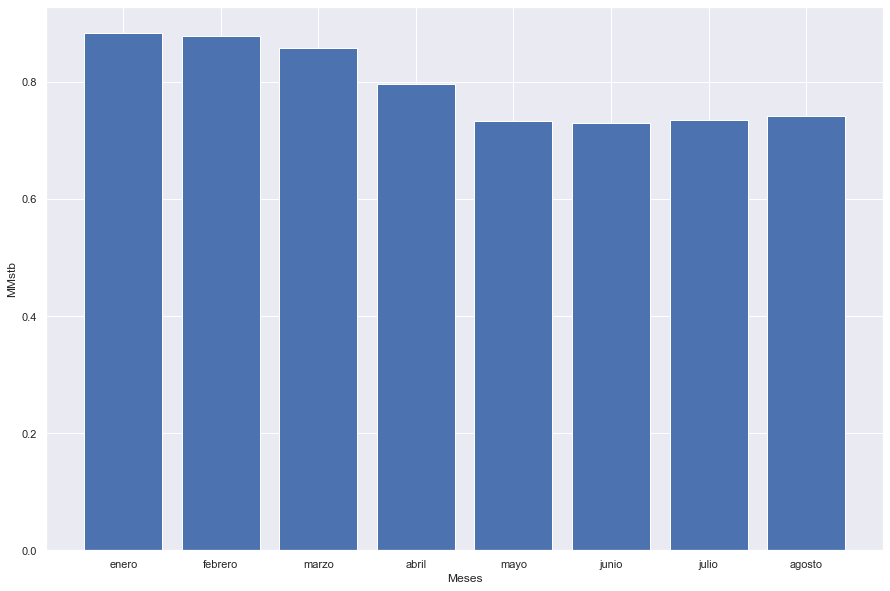

In [6]:
#Production by year Generate

for i in df_dict.keys():    
    Anual_Production=df_dict[i].copy()
    Production_Jan= Anual_Production.columns.get_loc("enero")
    x = np.arange(Anual_Production.iloc[:,Production_Jan::].shape[1])
    Anual_Production.loc['Anual_Prod']=(Anual_Production.iloc[:,Production_Jan::].fillna(0).sum(axis=0))/1000000
    months=list(Anual_Production.columns)[Production_Jan::]
    y_pplot=list(Anual_Production.loc['Anual_Prod'].iloc[Production_Jan::].fillna(0))
    fig, ax = plt.subplots(figsize=(15,10))
    plt.bar(x,y_pplot)
    plt.xticks(x, months)
    plt.xlabel('Meses')
    plt.ylabel('MMstb')
    plt.savefig(f'./interface/figs/{i}.png', bbox_inches = 'tight', pad_inches = 0)


## Database
The data can be also read from a SQLite Database as follows.

In [7]:
db_dir=Path('./database/anh_data.db')
conn = sqlite3.connect(db_dir)
c = conn.cursor()

The tables' names stored in the database can be retrieved as follows:

In [8]:
c.execute('''SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%';''').fetchall()

[('crude_2017',),
 ('crude_2016',),
 ('crude_2013',),
 ('crude_2019',),
 ('crude_2015',),
 ('crude_2014',),
 ('crude_2018',),
 ('crude_2020',)]

The `crude_2018` table's headers ca be retrieved as follows:

In [9]:
c.execute('''PRAGMA table_info(crude_2019)''').fetchall()

[(0, 'departamento', 'TEXT', 0, None, 0),
 (1, 'municipio', 'TEXT', 0, None, 0),
 (2, 'operadora', 'TEXT', 0, None, 0),
 (3, 'contrato', 'TEXT', 0, None, 0),
 (4, 'campo', 'TEXT', 0, None, 0),
 (5, 'enero', 'TEXT', 0, None, 0),
 (6, 'febrero', 'TEXT', 0, None, 0),
 (7, 'marzo', 'TEXT', 0, None, 0),
 (8, 'abril', 'TEXT', 0, None, 0),
 (9, 'mayo', 'TEXT', 0, None, 0),
 (10, 'junio', 'TEXT', 0, None, 0),
 (11, 'julio', 'TEXT', 0, None, 0),
 (12, 'agosto', 'TEXT', 0, None, 0),
 (13, 'septiembre', 'TEXT', 0, None, 0),
 (14, 'octubre', 'TEXT', 0, None, 0),
 (15, 'noviembre', 'TEXT', 0, None, 0),
 (16, 'diciembre', 'TEXT', 0, None, 0)]

Other queries are shown below:

In [10]:
c.execute('''SELECT * FROM crude_2018 LIMIT 1''').fetchall()

[('antioquia',
  'PUERTO NARE',
  'ecopetrol s.a.',
  'operacion-directa ecopetrol',
  'area teca-cocorna',
  '1290.88838709677',
  '1232.14785714286',
  '1146.54709677419',
  '1183.47233333333',
  '1264.54193548387',
  '1201.59633333333',
  '1276.36161290323',
  '1326.87032258065',
  '1404.01266666667',
  '1218.92483870968',
  '1333.641',
  '1373.87677419355')]

For example, the top 5 departamentos which produced crude in January 2018.

In [11]:
c.execute('''SELECT departamento, SUM(enero) AS total FROM crude_2018 GROUP BY crude_2018.departamento 
                ORDER BY total DESC LIMIT 5''').fetchall()

[('meta', 425024.3983870972),
 ('casanare', 162805.02645161285),
 ('santander', 62680.61967741938),
 ('arauca', 46571.40838709677),
 ('putumayo', 36501.45064516129)]

## Datasets 

In [12]:
widget_2020= qgrid.show_grid(df_dict['2020'],show_toolbar=True)
widget_2019= qgrid.show_grid(df_dict['2019'],show_toolbar=True)
widget_2018= qgrid.show_grid(df_dict['2018'],show_toolbar=True)

In [13]:
#Unfold, uncomment (or comment) and run one of the following queries to watch the dataset you want
widget_2020
#widget_2019
#widget_2018

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Data Analysis

In [14]:
#Function to display datasets side by side to save vertical space
#Input: dataframes and tables(dfs) titles

def dpy_side_by_side(dfs:list, titles:list):
    
    output = ""
    combined = dict(zip(titles, dfs))
    for title, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(title)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [15]:
#Identify null values in the datasets
dpy_side_by_side([df_dict['2018'].isnull().sum().to_frame(), df_dict['2019'].isnull().sum().to_frame(), df_dict['2020'].isnull().sum().to_frame()],["2018","2019","2020"])

,0
0,
departamento,0
municipio,0
operadora,0
contrato,0
campo,0
enero,0
febrero,0
marzo,0
abril,0


In [16]:
#Delete duplicates if there's any
df_dict['2018']=df_dict['2018'].drop_duplicates()
df_dict['2019']=df_dict['2019'].drop_duplicates()
df_dict['2020']=df_dict['2020'].drop_duplicates()

### Top 5 fields with the highest production in 2020

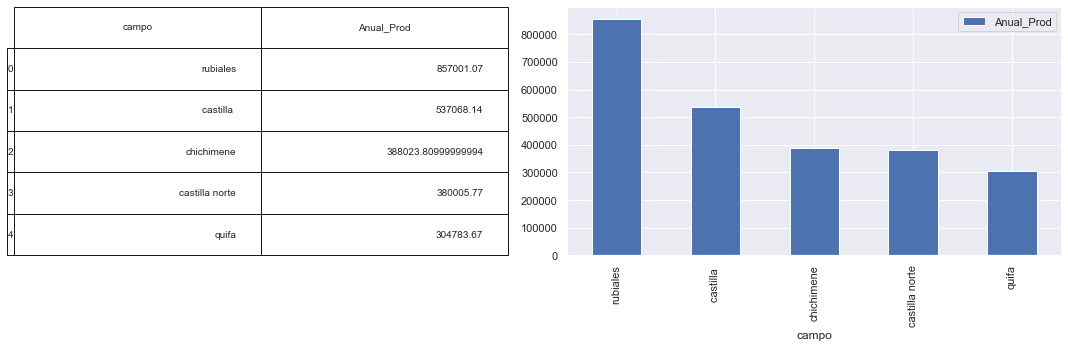

In [17]:
df_dict_2020=df_dict['2020'].copy()

#Get location of january in the dataset 
Jan_2020= df_dict_2020.columns.get_loc("enero")

#Get total production by row
df_dict_2020['Total_Prod']=df_dict_2020.iloc[:,Jan_2020::].fillna(0).sum(axis=1)

#Production 2020 by field
Prod_2020=df_dict_2020.groupby('campo')['Total_Prod'].sum().reset_index(name ='Anual_Prod')
#Top 5 anual production by field
Highest_Prod=Prod_2020.sort_values(by=['Anual_Prod'], ascending=False).iloc[0:5,:].reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
font_size=10
bbox=[0, 0, 1, 1]

#table visualization
mpl_table = ax1.table(cellText = Highest_Prod.values, rowLabels = Highest_Prod.index, bbox=bbox, colLabels=Highest_Prod.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=14
Highest_Prod.plot(x='campo', y='Anual_Prod', kind="bar",figsize=(15,5), ax=ax2)
fig.tight_layout()  


### Companies that have reported production in more than 5 fields in Casanare in 2018

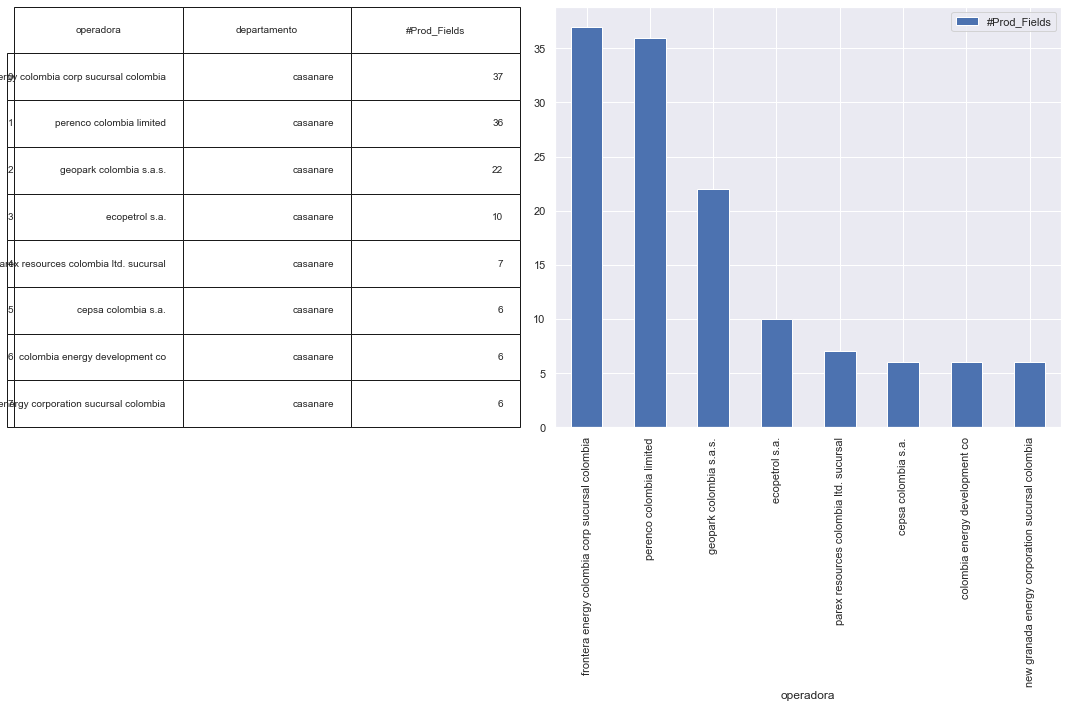

In [18]:
#Total production in 2018
df_dict_2018=df_dict['2018'].copy()
Jan_2018= df_dict_2018.columns.get_loc("enero")
df_dict_2018['Total_Prod']=df_dict_2018.iloc[:,Jan_2018::].fillna(0).sum(axis=1)

#Number of fields by companies
Op_Field_2018=df_dict_2018[df_dict_2018['Total_Prod']!=0]


Op_Field_2018=df_dict_2018.groupby(['operadora','departamento'])['campo'].count().reset_index(name ='#Prod_Fields')
Op_casanare_2018=Op_Field_2018[(Op_Field_2018['departamento']=='casanare')&(Op_Field_2018['#Prod_Fields']>5)]
casanare_2018=Op_casanare_2018.sort_values(by=['#Prod_Fields'], ascending=False).reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))  # 1 row, 2 columns
font_size=10

#table visualization
mpl_table = ax1.table(cellText = casanare_2018.values, rowLabels = casanare_2018.index, bbox=bbox, colLabels=casanare_2018.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=10
casanare_2018.plot(x='operadora', y='#Prod_Fields', kind="bar",figsize=(15,10), ax=ax2)
fig.tight_layout() 

### Top 5 contracts with the highest production in 2018

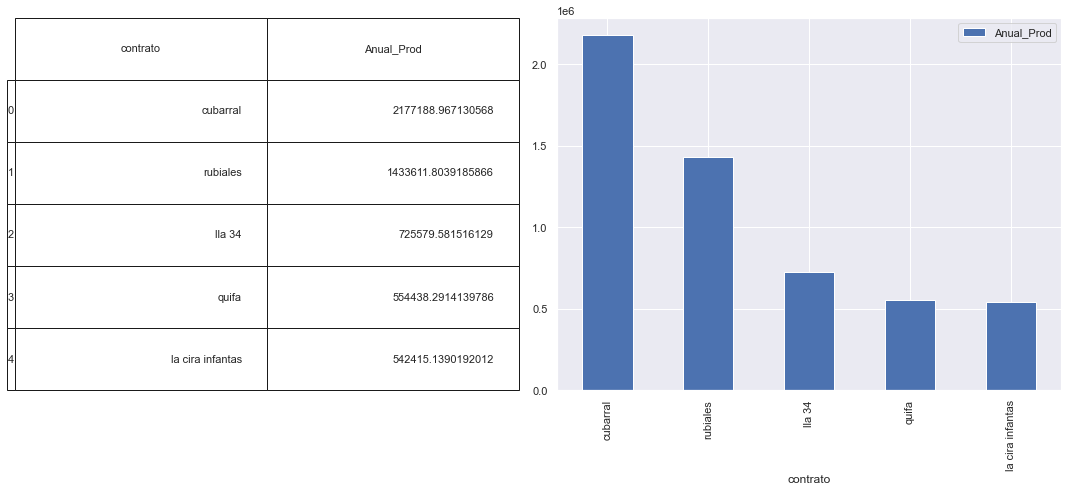

In [19]:
#Get production by contracts 
Cont_Highest_Prod= df_dict_2018.groupby('contrato')['Total_Prod'].sum().reset_index(name ='Anual_Prod')
#Get top 5 contracts with the highest production
Five_Hg_prod=Cont_Highest_Prod.sort_values(by=['Anual_Prod'], ascending=False).iloc[0:5].reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
bbox=[0, 0, 1, 1]

#table visualization
font_size=11
mpl_table = ax1.table(cellText = Five_Hg_prod.values, rowLabels = Five_Hg_prod.index, bbox=bbox, colLabels=Five_Hg_prod.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=11
Five_Hg_prod.plot(x='contrato', y='Anual_Prod', kind="bar",figsize=(15,7), ax=ax2)
fig.tight_layout()  

### Top 10 companies with the highest production in August 2019

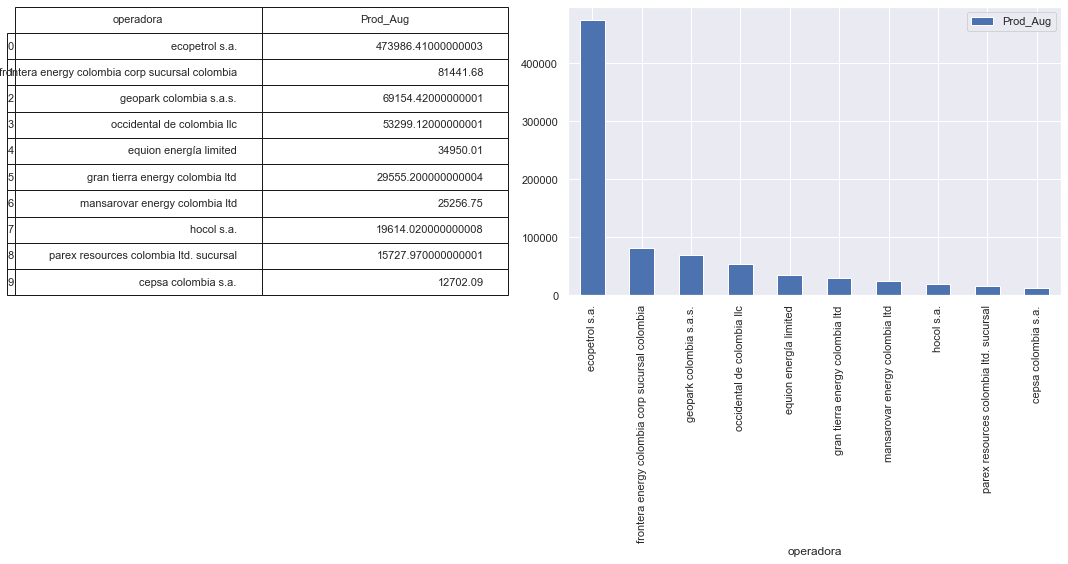

In [20]:
#Get production by company
Op_High_Prod_2019= df_dict['2019'].groupby('operadora')['agosto'].sum().reset_index(name ='Prod_Aug')
#Get top 10 companies with the highest production in Aug. 
Op_Hg_Pd_2019=Op_High_Prod_2019.sort_values(by=['Prod_Aug'], ascending=False).iloc[0:10].reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10))  # 1 row, 2 columns
bbox=[0, 0, 1, 1]

#table visualization
font_size=11
mpl_table = ax1.table(cellText = Op_Hg_Pd_2019.values, rowLabels = Op_Hg_Pd_2019.index, bbox=bbox, colLabels=Op_Hg_Pd_2019.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=11
Op_Hg_Pd_2019.plot(x='operadora', y='Prod_Aug', kind="bar",figsize=(15,8), ax=ax2)
fig.tight_layout() 

### <center> Comparative Analysis </center> 

In [21]:
#Get first quarter information
Tri_one_2019= df_dict['2019'].iloc[:,0:8]
Tri_one_2019= Tri_one_2019.copy()
Tri_one_2020= df_dict['2020'].iloc[:,0:8]
Tri_one_2020=Tri_one_2020.copy()
#total production by field 1st quarter
Tri_one_2019['total']= Tri_one_2019.iloc[:,5::].sum(axis=1)
Tri_one_2020['total']= Tri_one_2020.iloc[:,5::].sum(axis=1)

#Get second quarter information
Tri_two_2019= pd.concat([df_dict['2019'].iloc[:,0:5], df_dict['2019'].iloc[:,8:11]], axis=1)
Tri_two_2019=Tri_two_2019.copy()
Tri_two_2020= pd.concat([df_dict['2020'].iloc[:,0:5], df_dict['2020'].iloc[:,8:11]], axis=1)
Tri_two_2020=Tri_two_2020.copy()
#total production by field 2nd quarter
Tri_two_2019['total']= Tri_two_2019.iloc[:,5::].sum(axis=1)
Tri_two_2020['total']= Tri_two_2020.iloc[:,5::].sum(axis=1)

In [22]:
#Display the null values in the datasets
dpy_side_by_side([Tri_one_2019.isnull().sum().to_frame(),Tri_one_2020.isnull().sum().to_frame(),Tri_two_2019.isnull().sum().to_frame(),Tri_two_2020.isnull().sum().to_frame() ],
                 ['Null 1st Tri 2019','Null 1st Tri 2020','Null 2nd Tri 2019','Null 2nd Tri 2020'])

,0
0,
departamento,0
municipio,0
operadora,0
contrato,0
campo,0
enero,0
febrero,0
marzo,0
total,0


In [23]:
#Display the max, min, mean, std, Q1, Q2 an Q3 of the total production 
dpy_side_by_side([Tri_one_2019.describe(), Tri_two_2019.describe(), Tri_one_2020.describe(),  
                  Tri_two_2020.describe()],['Prod 1st Tri 2019','Prod 2nd Tri 2019','Prod 1st Tri 2020','Prod 2nd Tri 2020'])

0,total
count,456.000000
mean,5869.601820
std,24304.195939
min,0.000000
25%,160.915000
50%,747.445000
75%,3030.895000
max,361662.800000
0,total
count,456.000000


In [34]:
#Display the number of fields with zero production in the quarter
P0_2019_1=Tri_one_2019[Tri_one_2019['total']==0].count().to_frame()
P0_2020_1=Tri_one_2020[Tri_one_2020['total']==0].count().to_frame()
P0_2019_2=Tri_two_2019[Tri_two_2019['total']==0].count().to_frame()
P0_2020_2=Tri_two_2020[Tri_two_2019['total']==0].count().to_frame()

dpy_side_by_side([P0_2019_1,P0_2019_2,P0_2020_1,P0_2020_2],
                 ['# Fields Prod=0 1st Tri 2019','# Fields Prod=0 2nd Tri 2019','# Fields Prod=0 1st Tri 2020',
                  '# Fields Prod=0 2nd Tri 2020'])

,0
0,
departamento,42
municipio,42
operadora,42
contrato,42
campo,42
enero,42
febrero,42
marzo,42
total,42


Based on the description results and without further analysis, we could hypothesize that the current COVID-19 crisis affected the production since the maximum production went from approximately 361662 BPD in 2019 to 303165 BPD in 2020, as well as the mean production (from 5869 BPD to 5468 BPD). The previous results have shown that even though in the description we can see a reduction in the fields from 2019 to 2020, those fields in 2019 were actually non-productive ones. As we can visualize, in 2019 there were 42 to 44 non-productive fields in the first and second quarters. On the other hand, you can see a recovery in the first quarter of 2020, and then relapse in the second quarter of the same year.

,campo,Prod_field
0,rubiales,361662.800000
1,castilla,216521.040000
2,chichimene,150331.410000
3,quifa,136077.150000
4,castilla norte,130026.150000
5,la cira,92201.990000
6,pauto sur,82989.460000
7,jacana,74300.770000
8,caño limón,68446.020000
9,acordionero,61961.950000


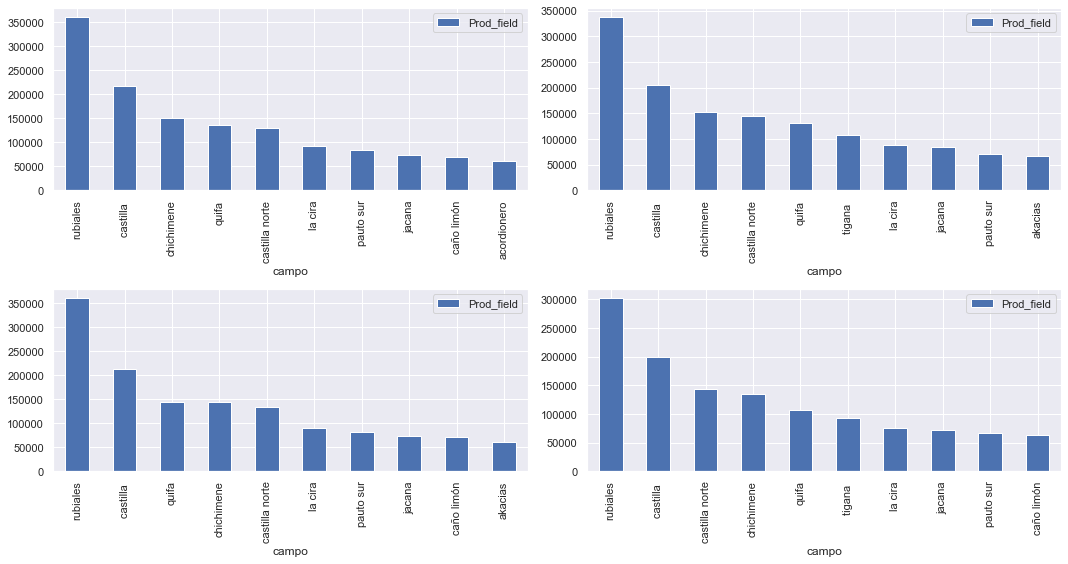

In [35]:
#Display Top 10 fields with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10field_2019_1= Tri_one_2019.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10field_2019_2=Tri_one_2020.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10field_2020_1=Tri_two_2019.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10field_2020_2=Tri_two_2020.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)

#call function to display results 
dpy_side_by_side([Top10field_2019_1,Top10field_2019_2,Top10field_2020_1,Top10field_2020_2],
                 ['Top Fields 1st Tri 2019','Top Fields 2nd Tri 2019','Top Fields 1st Tri 2020',
                  'Top Fields 2nd Tri 2020'])

#visualization
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))  # 1 row, 2 columns
font_size=11
Top10field_2019_1.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax1)
Top10field_2019_2.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax2)
Top10field_2020_1.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax3)
Top10field_2020_2.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax4)
fig.tight_layout() 

,departamento,Prod_dpto
0,meta,1331920.130000
1,casanare,521780.660000
2,santander,183903.810000
3,arauca,162828.550000
4,boyaca,98507.510000
5,putumayo,87649.000000
6,cesar,74442.430000
7,huila,71197.980000
8,antioquia,47367.510000
9,tolima,39952.570000


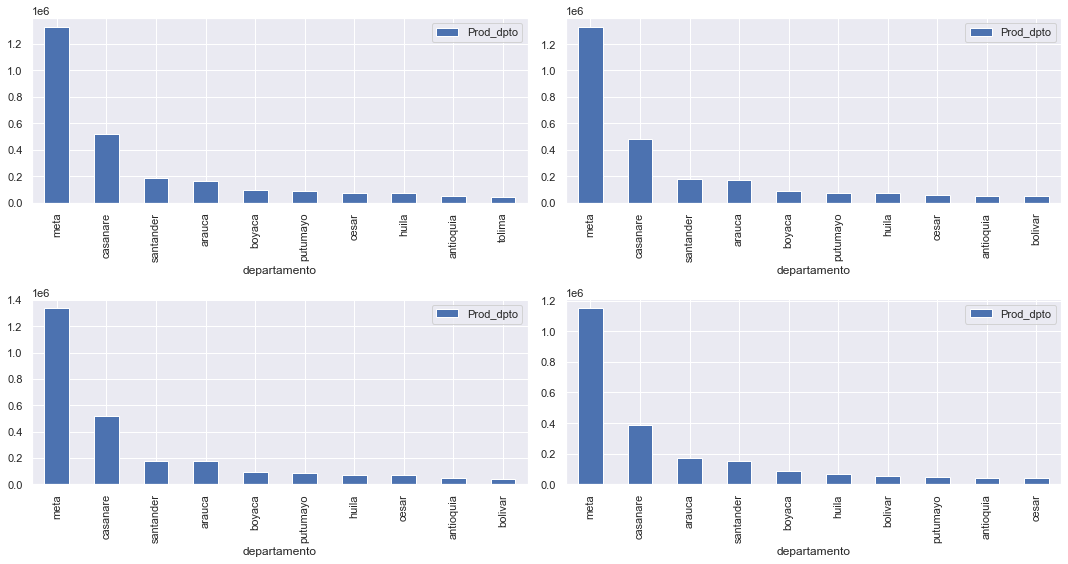

In [36]:
#Display Top 10 regions with the with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10dto_2019_1= Tri_one_2019.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10dto_2019_2=Tri_one_2020.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10dto_2020_1=Tri_two_2019.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10dto_2020_2=Tri_two_2020.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call funcion to display results
dpy_side_by_side([Top10dto_2019_1,Top10dto_2019_2,Top10dto_2020_1,Top10dto_2020_2],
                 ['Top dpto prod 1st Tri 2019','Top dpto prod 2nd Tri 2019','Top dpto prod 1st Tri 2020',
                  'Top dpto prod 2nd Tri 2020'])

#Visualization
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))  # 1 row, 2 columns
font_size=11
Top10dto_2019_1.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax1)
Top10dto_2019_2.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax2)
Top10dto_2020_1.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax3)
Top10dto_2020_2.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax4)
fig.tight_layout() 

In [37]:
#Display Top 10 fields by region with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest production during the first two quarters of 2019 and 2020
Top_DPtofield_2019_1= Tri_one_2019.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top_DPtofield_2019_2=Tri_one_2020.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top_DPtofield_2020_1=Tri_two_2019.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top_DPtofield_2020_2=Tri_two_2020.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call function to display results 
dpy_side_by_side([Top_DPtofield_2019_1,Top_DPtofield_2019_2,Top_DPtofield_2020_1,Top_DPtofield_2020_2],
                 ['Top fields by dpto prod 1st Tri 2019','Top fields by dpto prod 2nd Tri 2019','Top fields by dpto prod 1st Tri 2020',
                  'Top fields by dpto prod 2nd Tri 2020']) 

,departamento,campo,Prod_dpto
0,meta,rubiales,361662.800000
1,meta,castilla,216521.040000
2,meta,chichimene,150331.410000
3,meta,quifa,136077.150000
4,meta,castilla norte,130026.150000
5,santander,la cira,92201.990000
6,casanare,pauto sur,82989.460000
7,casanare,jacana,74300.770000
8,arauca,caño limón,68446.020000
9,cesar,acordionero,61961.950000


In [38]:
#Display Top 10 towns with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10mpio_2019_1= Tri_one_2019.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10mpio_2019_2=Tri_one_2020.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10mpio_2020_1=Tri_two_2019.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10mpio_2020_2=Tri_two_2020.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call function to display results 
dpy_side_by_side([Top10mpio_2019_1,Top10mpio_2019_2,Top10mpio_2020_1,Top10mpio_2020_2],
                 ['Top town prod 1st Tri 2019','Top town prod 2nd Tri 2019','Top town prod 1st Tri 2020',
                  'Top town prod 2nd Tri 2020'])

,municipio,Prod_mpio
0,PUERTO GAITAN,602779.230000
1,ACACIAS,315082.800000
2,CASTILLA NUEVA,224084.530000
3,TAURAMENA,147243.440000
4,BARRANCABERMEJA,140628.220000
5,YOPAL,122111.290000
6,ARAUCA,97641.960000
7,PUERTO BOYACA,97311.270000
8,VILLA NUEVA,96418.200000
9,SAN MARTÍN,69574.080000


The department of Meta is one of the largest oil producer regions since it has the Rubiales, Castilla, Chichimene fields, among others, which are the fields with the highest production recorded in 2019 and 2020. The decrease in production in these fields is remarkable through the quarters, but it is not crucial for the survival of the fields, unlike fields like Volcanera in the department of Casanare, whose reduction in production was low from the second quarter of 2019 to 2020, and this reduction was crucial for the survival of the field as it finally reached 0% production in the second quarter of 2020.

The same situation persists with the following results: 

In [39]:
#Display Top 10 companies with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10op_2019_1= Tri_one_2019.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10op_2019_2=Tri_one_2020.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10op_2020_1=Tri_two_2019.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10op_2020_2=Tri_two_2020.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call function to display results 
dpy_side_by_side([Top10op_2019_1,Top10op_2019_2,Top10op_2020_1,Top10op_2020_2],
                 ['Top companies 1st Tri 2019','Top companies 2nd Tri 2019','Top companies 1st Tri 2020',
                  'Top companies 2nd Tri 2020'])

,operadora,Prod_Op
0,ecopetrol s.a.,1439767.070000
1,frontera energy colombia corp sucursal colombia,243057.070000
2,geopark colombia s.a.s.,208932.030000
3,occidental de colombia llc,154958.680000
4,equion energía limited,110433.900000
5,gran tierra energy colombia ltd,107092.500000
6,mansarovar energy colombia ltd,78254.360000
7,hocol s.a.,58335.910000
8,cepsa colombia s.a.,45187.880000
9,parex resources colombia ltd. sucursal,37092.910000


,contrato,Prod_ctto
0,cubarral,557110.080000
1,rubiales,361662.800000
2,lla 34,206632.740000
3,quifa,144415.040000
4,la cira infantas,129915.620000
5,piedemonte,108215.740000
6,magdalena medio,98785.140000
7,cravo norte,81299.680000
8,nare,68697.850000
9,midas,62096.600000


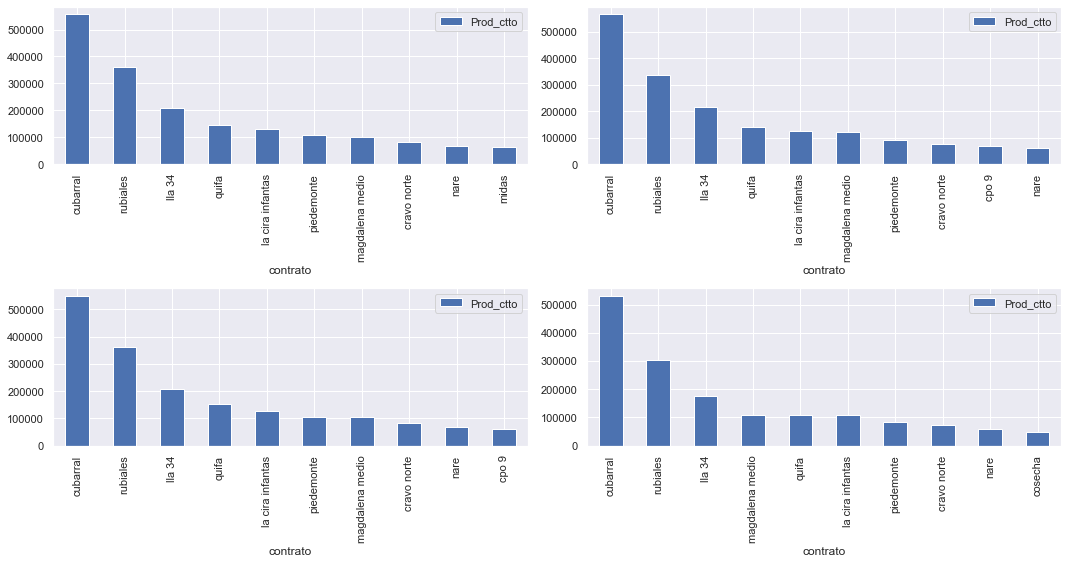

In [40]:
#Display Top 10 contracts with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10ctto_2019_1=Tri_one_2019.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10ctto_2019_2=Tri_one_2020.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10ctto_2020_1=Tri_two_2019.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10ctto_2020_2=Tri_two_2020.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)

dpy_side_by_side([Top10ctto_2019_1,Top10ctto_2019_2,Top10ctto_2020_1,Top10ctto_2020_2],
                 ['Top contracts 1st Tri 2019','Top contracts 2nd Tri 2019','Top contracts 1st Tri 2020',
                  'Top contracts 2nd Tri 2020'])

#Visualization
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))  # 1 row, 2 columns
font_size=11
Top10ctto_2019_1.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax1)
Top10ctto_2019_2.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax2)
Top10ctto_2020_1.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax3)
Top10ctto_2020_2.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax4)
fig.tight_layout() 

## Functions definition to apply universal methods to any type of dataset

In [41]:
# Takes a dictionary of dataFrames and for each, groups the information by a given column
def grouping_data(df_dict, column):
    df = {}
    for i in df_dict.keys():
        df_temp = df_dict[i].groupby(column).sum() # Grouping as needed
        if (i == '2014'): #Special treatment for missing months in the 2014 dataFrame
            df_temp['noviembre'] = 0.0
            df_temp['diciembre'] = 0.0
        if 'cuenca' in df_temp: df_temp.drop(columns='cuenca',inplace=True)
        January =   df_temp.columns.get_loc('enero')# picking the group first month location
        #December = df_temp.columns.get_loc('diciembre')# picking the last month location
        
        df[i] = df_temp.loc[:, 'enero'::] # Assign clean table
    return df

# Gets the production data from a specified field in a dataFrame
def actual_data(campo, df):
    production = np.array([])
    dates = pd.date_range(f'2000-01-01', periods=0, freq='M')

    #Actual data
    for i in df.keys():
        if campo in df[i].index:
            dates = np.append(dates, pd.date_range(f'{i}-01-01', periods= df[i].loc[campo,:].size, freq='M'))
            production = np.append(production, df[i].loc[campo,:])

    # The "decline rate" concept is valid as long as production does not increase,
    # thus, maximum production rate should be located for decline calculations
    max_prod = np.max(production)
    a = np.where(production == max_prod)[0][0]
    t_data  = dates[a::]
    prod_data = production[a::]
    
    return production, dates, max_prod, t_data, prod_data

# Decline rate equation employing the Arps' equation for hyperbolic conditions
def rate_arps_hyp(times, Di):
    global production, b_arps, max_prod
    t = np.arange(times.size)
    q = max_prod/(1. + b_arps*Di*t)**(1/b_arps)
    return q

# Decline rate, D, in hyperbolic is not constant ( D = - 1/q * dq/dt )
# Initial decline rate is a constant parameter for history matching: Di
def decline_rate(times, Di):
    global b_arps
    t = np.arange(times.size)
    D = Di / (1+b_arps*Di*t)
    return D


### Arps equation for Hyperbolic rate:

 $ q(t) = q_i / (1.0 + b D_i t)^\frac{1}{b}$

### Decline rate validation
In the following code, a criteria for grouping and a particular index can be choosen to depict its production data, oil decline history matching, and the initial and variable decline rate ($D$)

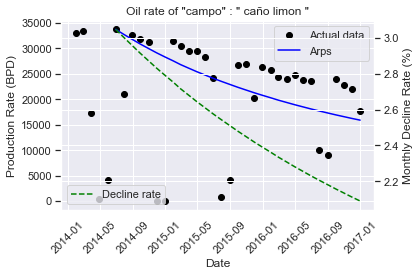

In [42]:
#Select hyperbolic exponent
b_arps = 0.5

#Select a grouping criterion and the desired index
criteria = 'campo'
index = "caño limon"

#Grouping data
df_group = grouping_data(df_dict,criteria)
index = index.lower()

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group)

#Optimizing decline rate
Di_opt, Di_cov = curve_fit(rate_arps_hyp, t_data, prod_data)

# Plotting data and fit
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil rate of "{criteria}" : " {index} "')

ax1.plot(dates, production,'o', color = 'black', label = 'Actual data')
ax1.plot(t_data, rate_arps_hyp(t_data, Di_opt),'-', color = 'blue', label = 'Arps')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Monthly Decline Rate (%)')
ax2.plot(t_data, decline_rate(t_data, Di_opt)*100,'--', color = 'green', label = 'Decline rate')

ax1.legend(loc='upper right')
ax2.legend(loc='lower left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Downloading, Loading & Cleanning Blind Data

In [43]:
#Using Pickle to save time during data loading
read = 1
if read:
    data = dataProc.dataProc()
    df = data.loadBlindData()
    df_blind = data.cleanBlindData(df)
    with open('df_blind.pickle', 'wb') as handle:
        pickle.dump(df_blind, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_blind.pickle', 'rb') as handle:
    df_blind = pickle.load(handle)


Loading data blind test finished
Cleanning blind data
Cleaning blind data finsihed


### Blind datasets

In [44]:
wid_blind_2019= qgrid.show_grid(df_blind['2019'],show_toolbar=True)
wid_blind_2018= qgrid.show_grid(df_blind['2018'],show_toolbar=True)
wid_blind_2017= qgrid.show_grid(df_blind['2017'],show_toolbar=True)

In [45]:
#Unfold, uncomment (or comment) and run one of the following queries to watch the dataset you want

wid_blind_2019
#wid_blind_2018
#wid_blind_2017

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Field "1F D2689F" Production rate in July, 2019

"campo" "1f-d2689f" in "julio - 2019" produced 4766.241346484784 barrels per day


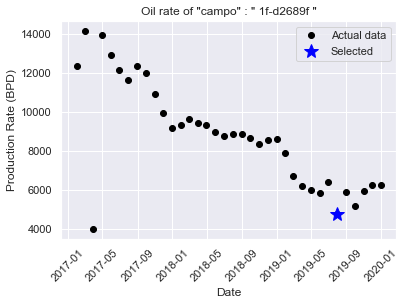

In [44]:
# Question 1 for blind test

#Select a grouping criterion and the desired index
criteria = 'campo'
index = '1F D2689F'
year = '2019'
month = 'julio'

#Grouping data
df_group_blind = grouping_data(df_blind,criteria)
index = index.lower().replace(" ","-")

# Getting the desired value to be reported
report = df_group_blind[year].loc[index,month]

# Printing the answer in the terminal
print(f'"{criteria}" "{index}" in "{month} - {year}" produced {report} barrels per day')

# Getting actual production data and locating of the desired value
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)
where = np.where(production == report)[0][0]

# Plotting data 
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil rate of "{criteria}" : " {index} "')
ax1.plot(dates, production,'o', color = 'black', label = 'Actual data')
ax1.plot(dates[where], production[where],'*', color = 'blue', label = 'Selected',markersize=15)
ax1.legend(loc='upper right')
plt.show()

## Total Production of Company "2FE52430" in February, 2019  

"operadora" "2fe52430" in "febrero - 2019" produced 208662.17260608985 barrels


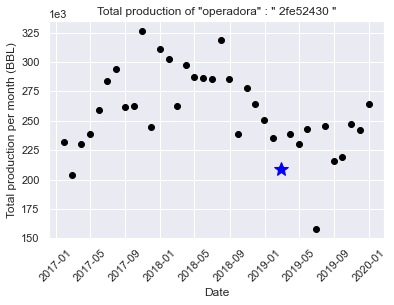

In [45]:
#Select a grouping criterion and the desired index
criteria = 'operadora'
df_group_blind = grouping_data(df_blind,criteria)
index = '2FE52430'
year = '2019'
month = 'febrero'

# Grouping data
index = index.lower().replace(" ","-")

# Getting the desired value to be reported
report = df_group_blind[year].loc[index,month] *  monthrange(int(year), 2)[1]

# Printing the answer in the terminal
print(f'"{criteria}" "{index}" in "{month} - {year}" produced {report} barrels')

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)

#Calculating the total production per month and locating of the desired value
dates_month = pd.DatetimeIndex(dates).month
days_per_month = np.array([monthrange(int(year), i)[1] for i in dates_month])
total_production = production*days_per_month
where = np.where(total_production == report)[0][0]

# Plotting data 
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Total production per month (BBL)')
ax1.set_title(f'Total production of "{criteria}" : " {index} "')
ax1.ticklabel_format(axis='y',style='sci',scilimits=(3,3))
ax1.plot(dates, total_production,'o', color = 'black', label = 'Actual data')
ax1.plot(dates[where], total_production[where],'*', color = 'blue', label = 'Actual data',markersize=15)
plt.show()

## Total production 

Total production (barrels) in 2018 by criteria: departamento

[ 3004801.89263314 18970777.53414348  3833958.25357653]


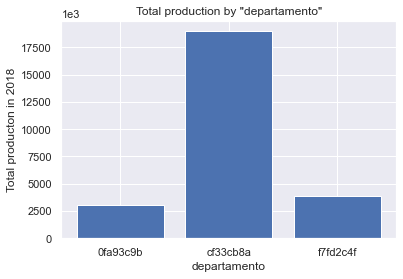

In [46]:
# Question 3 for blind test

#Select a grouping criterion and the desired index
criteria = 'departamento'
index = '2FE52430'
year = '2018'

# Grouping data
df_group_blind = grouping_data(df_blind,criteria)
index = index.lower().replace(" ","-")

# Calculating the days per month in a particular year
days_per_month = np.array([monthrange(int(year), i)[1] for i in np.arange(1,13)])

# Getting the desired value to be reported: dot product bewteen rates and days per month gives the total production in a year
report = np.dot(df_group_blind[year].iloc[:, :], days_per_month)

# Printing the answer in the terminal
print(f'Total production (barrels) in 2018 by criteria: {criteria}\n')
print(report)

# Plotting data
fig = plt.figure()
ax1 = plt.axes()
ax1.bar(df_group_blind[year].index, report)
ax1.set_xlabel(criteria)
ax1.set_ylabel(f'Total producton in {year}')
ax1.set_title(f'Total production by "{criteria}"')
ax1.ticklabel_format(axis='y', style='sci',scilimits=(3,3))

## Departments with the highest variation in per-field annual average production

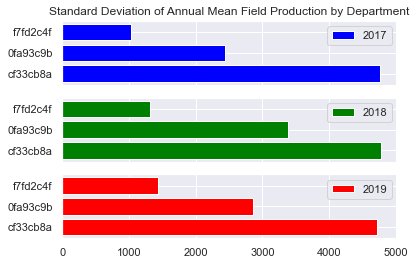

In [47]:
# Question 4 for blind test

df_4 = {}

# The criteria compares between departments
criteria = 'departamento'
for i in df_blind.keys():
    # Getting locations of first and last months
    df_temp = df_blind[i].copy()
    January =  df_temp.columns.get_loc('enero')# picking the first month location
    December = df_temp.columns.get_loc('diciembre')# picking the last month location

    # Calculating the annual mean production for each field in all years
    df_temp['Anual_Mean'] = np.mean(df_temp.iloc[:,January:December+1], axis=1)

    # Grouping by department using the standard deviation as aggregate
    df_4[i] = df_temp.groupby([criteria])['Anual_Mean'].aggregate('std')
    
    # Dropping nan (departments with only one field) and sorting arrays decreasingly
    df_4[i].dropna(inplace=True)
    df_4[i].sort_values(ascending=False, inplace=True)

# Plotting data
fig, ax = plt.subplots(3, sharex=True)
ax[0].barh(df_4['2017'][0:3].index, df_4['2017'][0:3], align='center', color = 'blue', label='2017')
ax[1].barh(df_4['2018'][0:3].index, df_4['2018'][0:3], align='center', color = 'green', label='2018')
ax[2].barh(df_4['2019'][0:3].index, df_4['2019'][0:3], align='center', color = 'red', label='2019')

ax[0].set_title('Standard Deviation of Annual Mean Field Production by Department');

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right')
plt.show()

## Average Monthly Decline Rate for Field "51CBB05D" using Arps with $b=0.5$

### Decline rate is defined as: 
 $D = f(q)= -\frac{1}{q} \frac{dq}{dt}$
where 
 $D = f (q_0) = D_i$

 D_i is a constant parameter that can be adjusted to fit the production data.
 
However, as $D$ depends on $q$, the average decline rate $D$ can be different from $D_i$

 Both, $D$ and $D_i$ are reported here

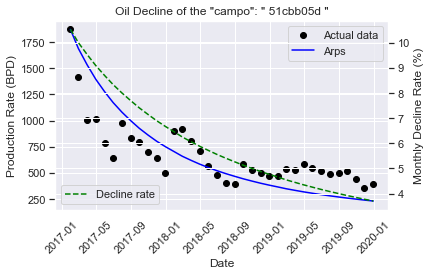

Initial Decline Rate (%): [10.53855872]
Total Average of Monthly Decline is 6.006171032288183 % for "campo": "51cbb05d"


In [48]:
#Selecting hyperbolic exponent
b_arps = 0.5

#Select a grouping criterion and the desired index
criteria = 'campo'
index = "51CBB05D"

#Grouping data
df_group_blind = grouping_data(df_blind,criteria)
index = index.lower().replace(" ","-")

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)

#Sorting production as dates are not in order 
i = np.argsort(dates)
i2 = np.argsort(t_data)

#Optimizing decline rate
Di_opt, Di_cov = curve_fit(rate_arps_hyp, t_data[i2], prod_data[i2])

# Plotting data and fit
fig = plt.figure()
ax1 = plt.axes()

ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil Decline of the "{criteria}": " {index} "')
ax1.plot(dates[i], production[i],'o', color = 'black', label = 'Actual data')
ax1.plot(t_data[i2], rate_arps_hyp(t_data[i2], Di_opt),'-', color = 'blue', label = 'Arps')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.set_ylabel('Monthly Decline Rate (%)')
ax2.plot(t_data[i2], decline_rate(t_data[i2], Di_opt)*100,'--', color = 'green', label = 'Decline rate')

ax1.legend(loc='upper right')
ax2.legend(loc='lower left')
plt.show()

# Printing the answer in the terminal
print(f'Initial Decline Rate (%): {Di_opt*100}')
print(f'Total Average of Monthly Decline is {np.mean(decline_rate(t_data[i2], Di_opt)*100)} % for "{criteria}": "{index}"')


## Decrypting blindtest 

In [49]:
## Decrypting the blind test
company = {}
department = {}
municipality = {}
field = {}
contract = {}

################ YEAR 2018 ########################

#Step zero: Count appearances of companies, contracts, and fields in 2018 file
#First step: Selecting companies with 23 or more contracts 
company_possible = ['ECOPETROL S.A.','Frontera Energy Colombia Corp Sucursal Colombia',
    'HOCOL S.A.','OCCIDENTAL DE COLOMBIA LLC', 'PERENCO COLOMBIA LIMITED']

#Second step: Which companies have a contract with 8 or more appearences? Contract: '1f-d2689f'
company_possible = ['ECOPETROL S.A.','Frontera Energy Colombia Corp Sucursal Colombia'
    ,'OCCIDENTAL DE COLOMBIA LLC', 'PERENCO COLOMBIA LIMITED']

#Third step: Which entries have the same contract and field name?
company_possible = ['ECOPETROL S.A.','OCCIDENTAL DE COLOMBIA LLC']

#Fourth step: Which entry have more than 1 appeareance (two different municipalities)
company.update({'d5580f74': "OCCIDENTAL DE COLOMBIA LLC"})

department.update({'cf33cb8a':'ARAUCA'})

municipality.update({'cf33cb8a':'ARAUCA',
                     '102a28a6':'ARAUQUITA'})

field.update({'1f-d2689f':'CHIPIRÓN',
              '1fd2689f' :'CHIPIRÓN'})

contract.update({'1f-d2689f':'CHIPIRÓN'})

#Filling with the new findings, in ARAUCA department, there are only two municipalities in the dataframe:
# TAME and SARAVENA. However, only TAME appears twice, as in the blind test
municipality.update({'5abe4339':'TAME'})
company.update({'ffd6d24d':'PAREX RESOURCES COLOMBIA LTD. SUCURSAL'})
contract.update({'876a64fe':'CAPACHOS'})
field.update({'fd6f6562':'ANDINA',
              '876a64fe':'CAPACHOS'})

# PAREX has operations in ARAUCA and CASANARE, what gives the next key
department.update({'f7fd2c4f':'CASANARE'})

#Looking for PAREX, this company has two entries appearing twice, one of them in the same contract. Then:
municipality.update({'76acd11e':'VILLA NUEVA'})
contract.update({'81c9dc26':'CABRESTERO'})
field.update({'8dd7c41b':'BACANO',
              '82edafb9':'AKIRA'})

# and
municipality.update({'6feb5887':'SAN LUIS DE PALENQUE'})
contract.update({'73dec126':'LOS OCARROS',
                 'f67a6350':'LLA 30'})
field.update({'c98bd9dd':'ADALIA',
              '51cbb05d':'LAS MARACAS'})

#The missing entries for PAREX
municipality.update({
    '1218f7fa':'PORE',
    '21d4886b':'PAZ DE ARIPORO',
    '48399655':'AGUAZUL'})

contract.update({
    '2d2fa4e7':'LLA 16',
    'b93bf597':'LLA 40',
    '0602f724':'LLA 26'})

field.update({
    '741abe20':'KONA',
    '4d0fb45e':'BEGONIA',
    '58a0d8ca':'RUMBA' })

# Following the logic with OCCIDENTAL, apart from CHIPIRÓN, the company
# has other 3 contracts with counts of 2, 6, and 7. Accordingly, we have:

contract.update({
    '29ded6f4':'CRAVO NORTE',
    'a1fdefb8':'COSECHA',
    'ea18fc5d':'RONDÓN'})
# Comparing production between fields in a single contract:
field.update({
    '043b305e':'CAÑO YARUMAL',
    '1d31fa4e':'REDONDO ESTE',
    '2f614c0b':'CAÑO LIMÓN',
    '3f67010a':'REDONDO',
    'fca93f9e':'TONINA'})

# From COSECHA
field.update({
    '0e01f88f':'MORROCOY',
    '124207de':'FINN',
    '241d3779':'REX',
    '3f10a1f5':'CANAGUEY',
    '5559f8d7':'REX NE',
    '5dd16431':'TERECAY',
    'c6da2541':'GOLONDRINA'})

#from RONDÓN
field.update({'c728bf96':'CAÑO RONDÓN',
    'febb6cf6':'CARICARE'})

#missing from CHIPIRÓN
field.update({ '13276557':'ARAGUATO',
    '1ab355bf':'JIBA UNIFICADO',
    '254d7db5':'MATANEGRA OESTE',
    '9ac1420f':'GALEMBO',
    '9b395bc9':'MACANA',
    'c220f014':'BAYONERO'})

#Filtrating in CASANARE by 3 or more appearences in contracts and companies, and discarding the already identified cities
# turns out that there is only one field which stops production from March to June, what can be matched in the blind dataset

municipality.update({'16b873c5':'OROCUE'})
company.update({'2fe52430':'VETRA EXPLORACION Y PRODUCCION COLOMBIA S.A.S.'})
contract.update({'0191a2e4':'CDNDI LA PUNTA'})
field.update({'7eb34927':'JUAPE',
              '4f4a249f':'SANTO DOMINGO',
              '8ba362f3':'SANTO DOMINGO NORTE',})

#Finally, once the last company was identified, the following information can be found:

department.update({'0fa93c9b':'PUTUMAYO'})
municipality.update({'756c486f':'PUERTO ASIS'})
contract.update({'4b05ae15':'SURORIENTE'})
field.update({
    '48670499':'COHEMBI',
    '373ebdec':'QUILLACINGA',
    'e32e23a1':'QUINDE'})
###################################################

################ YEAR 2017 ########################

# Replacing known keys, looking for OCCIDENTAL DE COLOMBIA, and removing already known contracts,
# it is straightforward to identify two new mappings in the 2017 year

contract.update({'76a16657':'CHIPIRON',
                 'ab8c6300':'RONDON'})

#from RONDON

field.update({'c728bf96':'CAÑO RONDÓN',
              'febb6cf6':'CARICARE'})

#from CHIPIRÓN
field.update({'1f d2689f':'CHIPIRÓN'})


#Once OCCIDENTAL was completed, following company, PAREX, has only one municipality missing
municipality.update({'e1745f70':'VILLANUEVA'})
contract.update({'796c2e32':'CABRESTERO PAREX'})
field.update({'82edafb9':'AKIRA',
              '8dd7c41b':'BACANO',
              'b111ec69':'KITARO'})
#other contracts in known municipalities
contract.update({'5f512199':'E&P LLANOS 26',
                'e068232a':'E&P LLANOS 40',
                '1ef80899':'E&P Llanos 16 Contrato # 45',
                'af29b5ed':'E&P LLANOS 30',
                'e753d35d':'E&P LOS OCARROS PAREX'})

# from missing departments for PAREX (2 entries)
department.update({'5f559ecb':'BOYACA',
                   'eccb9ef1':'META'})
municipality.update({'95c9d783':'PUERTO BOYACA',
                     '870c4a0b':'CABUYARO'})
contract.update({'6e6815e2':'VMM-11',
                 'a3d02126':'CERRERO'})
field.update({'c6ba0174':'GLAUCA',
              '27cb99a2':'KATMANDÚ NORTE'})

#Finally, from VETRA, only an already identified city was missing (PUERTO ASIS)
contract.update({'b4dad5fa':'CPI SUR ORIENTE'})
field.update({'48670499':'COHEMBI',
              '373ebdec':'QUILLACINGA',
              'e32e23a1':'QUINDE'})

###################################################

################ YEAR 2019 ########################

contract.update({'1f d2689f':'CHIPIRÓN'})

#after assigning known values, a contract associated to VETRA was missing

contract.update({'23980b82':'LA PUNTA'})
field.update({'7eb34927':'JUAPE',
              '4f4a249f':'SANTO DOMINGO',
              '8ba362f3':'SANTO DOMINGO NORTE'})

# CHIPIRÓN contract has a new entry
field.update({'649eeafb':'JIBA'})

#CAPACHOS contract has a new entry
field.update({'d56beadb':'ANDINA NORTE'})

# Finally, there are two deparments with not assignment, but belonging to PAREX
# No filtrating by ARAUCA or CASANARE, a department with a single municipality
department.update({'ec12ad00':'CESAR'}) 
municipality.update({'dfb943a1':'RIO DE ORO'})
contract.update({'68f1a111':'FORTUNA'})
field.update({'85c1a0e5':'HABANERO',
              '5558f26e':'PIMIENTO',
              '44502c89':'TOTUMAL'})

#The last department
department.update({'657b6154':'SANTANDER'}) 

#Repeated city: RIO NEGRO
municipality.update({'a6b36c07':'RIO NEGRO',
                     '28b6a6a0':'SIMACOTA'})
contract.update({'38c31ea1':'CONVENIO BORANDA',
                 '8568d01e':'AGUAS BLANCAS'})
field.update({'11e586b4':'BORANDA',
              '8568d01e':'AGUAS BLANCAS'})


###################################################

print('\nDepartamento\n', department)
print('\nMunicipio\n', municipality)
print('\nOperadora\n', company)
print('\nContrato\n', contract)
print('\nCampo\n', field)


Departamento
 {'cf33cb8a': 'ARAUCA', 'f7fd2c4f': 'CASANARE', '0fa93c9b': 'PUTUMAYO', '5f559ecb': 'BOYACA', 'eccb9ef1': 'META', 'ec12ad00': 'CESAR', '657b6154': 'SANTANDER'}

Municipio
 {'cf33cb8a': 'ARAUCA', '102a28a6': 'ARAUQUITA', '5abe4339': 'TAME', '76acd11e': 'VILLA NUEVA', '6feb5887': 'SAN LUIS DE PALENQUE', '1218f7fa': 'PORE', '21d4886b': 'PAZ DE ARIPORO', '48399655': 'AGUAZUL', '16b873c5': 'OROCUE', '756c486f': 'PUERTO ASIS', 'e1745f70': 'VILLANUEVA', '95c9d783': 'PUERTO BOYACA', '870c4a0b': 'CABUYARO', 'dfb943a1': 'RIO DE ORO', 'a6b36c07': 'RIO NEGRO', '28b6a6a0': 'SIMACOTA'}

Operadora
 {'d5580f74': 'OCCIDENTAL DE COLOMBIA LLC', 'ffd6d24d': 'PAREX RESOURCES COLOMBIA LTD. SUCURSAL', '2fe52430': 'VETRA EXPLORACION Y PRODUCCION COLOMBIA S.A.S.'}

Contrato
 {'1f-d2689f': 'CHIPIRÓN', '876a64fe': 'CAPACHOS', '81c9dc26': 'CABRESTERO', '73dec126': 'LOS OCARROS', 'f67a6350': 'LLA 30', '2d2fa4e7': 'LLA 16', 'b93bf597': 'LLA 40', '0602f724': 'LLA 26', '29ded6f4': 'CRAVO NORTE', 'a1fdef